# Assignment 2: Social Graphs and Interactions (02805)
### November 5, 2024

**Contributors:**
- Victor Larsen-Saldeen
- Andreas Bardram
- Thomas Schioler Hansen


# **Analysis of the 2024 US Presidential Election**

This project is about the 2024 US presidential election, where we through a combination of network science and word analysis want to take a look at how the media portrayed the election. We want to see if we can find interesting insights in how the media covered the election through a data-driven analysis of the following questions:

1. Which politicians were mentioned most frequently by news stations?

2. How often were different politicians discussed in relation to one another?

3. What topics received the most coverage from these news stations?

4. Is there evidence of bias in how certain politicians were portrayed, either positively or negatively?

5. How did media sentiment evolve during major events of the election cycle?

6. Were there differences in how conservative and liberal media outlets portrayed the election?

## **Steps Taken in the Analysis**

We will explain everything further when we get into the analysis, but here is a quick overview of what we have done. We have collected 9560 news articles through the newsAPI, and after filtering error links and empty articles out, we ended up with 7506 news articles from different media. To get the entire articles, we used to newspaper library. 

When creating the network, we used Named Entity Recognition (NER), to ensure that for example Donald, Trump, Donald Trump, Donald J. Trump etc. are recognized as the same politician. After doing that we could start to create our network, where we have politicians as nodes and the edges connecting different politicians in the network is whenever these politicians are mentioned in the same article.

This network is used to see which politician is talked about the most, by seeing how many out-degree of the different politicians have and give a visual representation of the media coverage of the different politicians.

We have made a TF-IDF anylysis to see which subjects were talked about most in our selection of news articles.

We have made a sentiment analysis of each politician, where we have taken the 20 words before and the 20 words after a politician name and used word lists to determine whether different politicians are talked about more positively about than others. We used these sentiment scores too, to see if they change over time by plotting different important events in the election and looked at if you could see a difference in the sentiment towards the politicians involved in these key events.

We made a biparte graph to visualize which politicians democratic media and conservative media talks more about.

# Notebook Structure and Flow


## **Loading Data**

We start by loading the the, as mentioned in the presentation of the project we have collected 9560 news articles through the newsAPI, and after filtering error links and empty articles out, we ended up with 7506 news articles from different media. To get the entire articles, we used to newspaper library. Here we take the first steps to load the data, and moved everything here such that we only need to make the imports once:

- We moved the imports and loading of the dataset and models to the top so they are only loaded once.
- We ensured that the nlp model is loaded only if not already loaded.
- We initialized the sentiment analyzer once.

# Imports

In [ ]:
import datetime
import time
import pandas as pd
import os
import math
import sys
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import networkx as nx
import spacy
import pickle
from collections import defaultdict, Counter
import requests
import json
from tqdm import tqdm
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.lines as mlines
import matplotlib.patches as mpatches
import matplotlib.cm as cmx
import re
import matplotlib.dates as mdates
from sklearn.metrics.pairwise import cosine_similarity
from community import community_louvain
import matplotlib.cm as cm
from networkx.algorithms.community.quality import modularity
import numpy as np
from fa2_modified import ForceAtlas2
from operator import itemgetter
import powerlaw
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from spacy.matcher import PhraseMatcher


# Data Collection

**NewsAPI** is used to fetch metadata about news articles. This includes information such as the source, author, title, description, publication date, and a shortened version of the content.

For the data collection code, you will need to add an API key to run it.

In [ ]:
from newspaper import Article
from newsapi import NewsApiClient

In [15]:
api_key = ""  
newsapi = NewsApiClient(api_key=api_key)

input_file = "news_articles_election_candidates_expanded.csv"
full_content_file = "news_articles_election_candidates_full_content.csv"

**Fetching full article content:** URLs collected during metadata fetching are processed using newspaper3k to extract the full text of the articles.

In [16]:
# Function to fetch full article content using newspaper3k
def fetch_full_content(article_url):
    try:
        article = Article(article_url)
        article.download()
        article.parse()
        return article.text 
    except Exception as e:
        return None 

start_date = datetime.date(2024, 10, 12) 
end_date = datetime.date(2024, 8, 1)  

articles_data = []

**Queries** are created to focus on topics related to the 2024 U.S. Presidential Election.

In [17]:
# Expanded search queries
queries = [
    "2024 Presidential election",
    "US election AND (Donald Trump OR Kamala Harris)",
    "Biden administration AND 2024 election",
    "(Donald Trump OR Trump) AND 2024 election",
    "(Kamala Harris OR Harris) AND 2024 election",
    "Campaign financing AND 2024 election",
    "Voter turnout AND 2024 election",
    "Presidential debate AND 2024 election",
    "(Donald Trump OR Trump) AND rally AND 2024",
    "(Kamala Harris OR Harris) AND speech AND 2024",
    "(Donald Trump OR Kamala Harris) AND 2024 election",
    "(Trump OR Harris) AND campaign AND 2024 election"
]

In [ ]:
# Track API request count
request_count = 0
max_requests = 100 

# Load CSV files
existing_expanded_data = pd.read_csv(input_file) if os.path.exists(input_file) else pd.DataFrame()
existing_full_content_data = pd.read_csv(full_content_file) if os.path.exists(full_content_file) else pd.DataFrame()

# Track URLs
existing_urls = set(existing_expanded_data["url"]) if not existing_expanded_data.empty else set()
processed_urls = set(existing_full_content_data["url"]) if not existing_full_content_data.empty else set()

**Duplicate Filtering:** URLs of already processed articles (from previously saved data files) are tracked to avoid fetching duplicate articles

In [ ]:
# Fetch new articles from NewsAPI
current_date = start_date
while current_date >= end_date:
    date_str = current_date.strftime('%Y-%m-%d')
    print(f"Fetching articles for {date_str}...")

    for query in queries:
        try:
            if request_count >= max_requests:
                print("Reached API limit for the day. Exiting script.")
                sys.exit()

            # Fetch articles for the current query and date
            response = newsapi.get_everything(
                q=query,
                from_param=date_str,
                to=date_str,
                language="en",
                sort_by="relevancy",
                page_size=100
            )

            request_count += 1

            if response.get('status') != 'ok':
                print(f"API error: {response.get('message')}")
                sys.exit()

            # Process the articles
            if response.get('articles'):
                for article in response['articles']:
                    if article['url'] not in existing_urls:
                        articles_data.append({
                            "query": query,
                            "source": article['source']['name'],
                            "author": article['author'],
                            "title": article['title'],
                            "description": article['description'],
                            "url": article['url'],
                            "published_at": article['publishedAt'],
                            "content": article['content']
                        })
                        existing_urls.add(article['url'])
        except Exception as e:
            with open("error_log.txt", "a") as log_file:
                log_file.write(f"Error fetching articles for {query} on {date_str}: {e}\n")
            print(f"Error fetching articles for {query} on {date_str}: {e}")
    
    # Move to the previous day
    current_date -= datetime.timedelta(days=1)
    time.sleep(1)

# Save new articles to the expanded CSV file
if articles_data:
    new_data_df = pd.DataFrame(articles_data)
    new_data_df.to_csv(input_file, mode='a', header=not os.path.exists(input_file), index=False)
    print(f"Appended {len(new_data_df)} new articles to '{input_file}'.")

In [ ]:
# Extract full content for new articles only
new_urls = {article["url"] for article in articles_data}
urls_to_process = new_urls - processed_urls

if urls_to_process:
    full_content_data = []
    for url in urls_to_process:
        print(f"Fetching full content for {url}...")
        full_content = fetch_full_content(url)
        if full_content:
            metadata = next((article for article in articles_data if article["url"] == url), {})
            full_content_data.append({
                "query": metadata.get("query"),
                "source": metadata.get("source"),
                "author": metadata.get("author"),
                "title": metadata.get("title"),
                "description": metadata.get("description"),
                "url": url,
                "published_at": metadata.get("published_at"),
                "content": metadata.get("content"),
                "full_content": full_content
            })
        else:
            print(f"Failed to fetch full content for {url}")

    # Save full content with metadata to CSV
    if full_content_data:
        full_content_df = pd.DataFrame(full_content_data)
        full_content_df.to_csv(full_content_file, mode='a', header=not os.path.exists(full_content_file), index=False)
        print(f"Appended {len(full_content_df)} new full content articles with metadata to '{full_content_file}'.")
else:
    print("No new articles to process for full content.")

## Clean the data

In [ ]:
input_file = "news_articles_election_candidates_full_content.csv"
output_file = "news_articles_election_candidates_full_content_cleaned.csv"

data = pd.read_csv(input_file)

# Drop rows with mising data
cleaned_data = data.dropna(subset=["full_content", "source", "published_at"])

# Save
cleaned_data.to_csv(output_file, index=False)

## Display the Data

In [22]:
# Load the dataset
data_full_content = pd.read_csv('news_articles_election_candidates_full_content_cleaned.csv')

In [23]:
data_full_content.head()

query            source  \
0  2024 Presidential election             Wired   
1  2024 Presidential election         The Verge   
2  2024 Presidential election               NPR   
3  2024 Presidential election  Business Insider   
4  2024 Presidential election              CNET   

                                              author  \
0                         Lily Hay Newman, Tess Owen   
1                                      Justine Calma   
2                                        Megan Pratz   
3  insider@insider.com (John L. Dorman,Kelsey Vla...   
4                                        Thomas Kika   

                                               title  \
0  Russia Is Going All Out on Election Day Interf...   
1  Apple News will let you watch election results...   
2  Here's how NPR will report the 2024 election r...   
3  The 2024 presidential election may come down t...   
4  How Do I Keep Track of Official Election Resul...   

                                         description  \
0  Along with other foreign influence operations—...   
1  On Election Day in the US, Apple News is rolli...   
2  NPR relies on results and race calls from The ...   
3  Election results in the swing states of Arizon...   
4  An avalanche of Election Day 2024 coverage is ...   

                                                 url          published_at  \
0  https://www.wired.com/story/russia-election-di...  2024-11-05T21:04:35Z   
1  https://www.theverge.com/2024/11/5/24288777/el...  2024-11-05T16:34:12Z   
2  https://www.npr.org/2024/11/04/g-s1-31268/2024...  2024-11-05T10:00:00Z   
3  https://www.businessinsider.com/what-are-2024-...  2024-11-05T22:13:18Z   
4  https://www.cnet.com/tech/services-and-softwar...  2024-11-05T17:45:00Z   

                                             content  \
0  As the 2024 US presidential election comes to ...   
1  Image: Cath Virginia / The Verge\r\n\n \n\n Fo...   
2  Voters have been voting, ballots will be count...   
3  Over the past two decades, the road to the Whi...   
4  As if the 2024 election reporting could be any...   

                                        full_content  
0  As the 2024 US presidential election comes to ...  
1  For anyone obsessively watching election resul...  
2  Here's how NPR will report the 2024 election r...  
3  On Election Day 2024, both parties are eyeing ...  
4  All anyone is talking about today is the presi...

In [24]:
print("\n Data Attributes:")
for column in data_full_content.columns:
    print(f"- {column}")


 Data Attributes:
- query
- source
- author
- title
- description
- url
- published_at
- content
- full_content


### Number of Articles per Outlet

We have decided to display only the 40 news outlets with most articles in the dataset to get an overview over what kind of media sources we have in the data.

The number of unique sources in the dataset is: 454


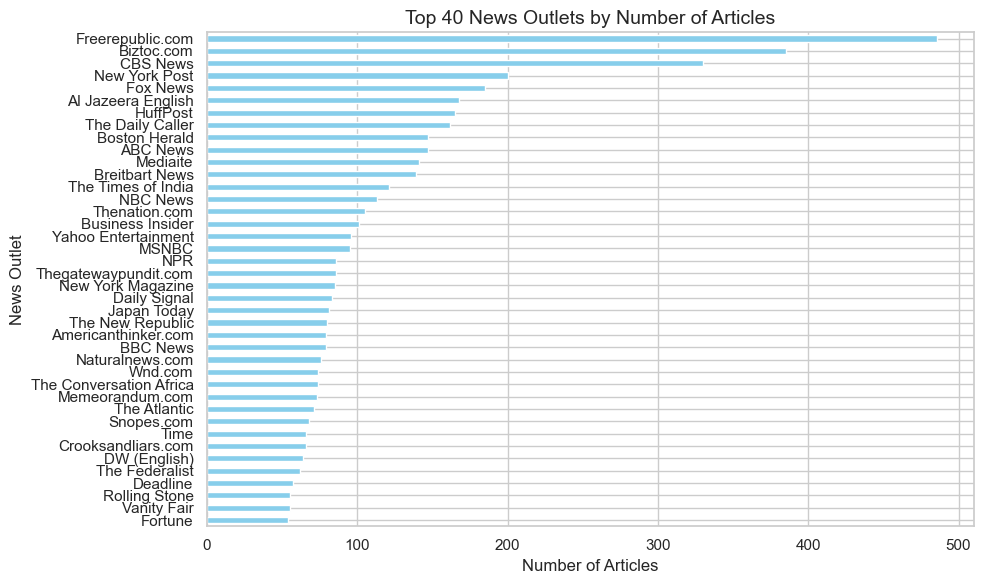

In [94]:
source_counts = data_full_content['source'].value_counts()

num_sources = len(source_counts)

print(f"The number of unique sources in the dataset is: {num_sources}")

# Filter top 20 news outlets by article count
top_outlets = source_counts.head(40)

# Plot a horizontal bar chart
plt.figure(figsize=(10, 6))
top_outlets.sort_values().plot(kind='barh', color='skyblue')
plt.title("Top 40 News Outlets by Number of Articles", fontsize=14)
plt.xlabel("Number of Articles", fontsize=12)
plt.ylabel("News Outlet", fontsize=12)
plt.tight_layout()
plt.show()



# Text Exploration and Analysis

## Politician Entity Recognition and Mentions

- **NLP Model:** We use the transformer-based en_core_web_trf spaCy model.

- **Collect Politician Aliases:** We automatically retrieve the politician aliases using a SPARQL query to fetch current U.S. Senators and Representatives from Wikidata along with their aliases. In addition, we have a manual_politicians.json file that supplements this automated data with additional or custom politician aliases.

- **Alias-to-Canonical Mapping:** A mapping (alias_to_canonical) is created to link all known aliases to a standardized canonical name for consistency.


In [ ]:
# Load the spaCy English model
try:
    nlp = spacy.load("en_core_web_trf")
except OSError:
    spacy.cli.download("en_core_web_trf")
    nlp = spacy.load("en_core_web_trf")

# Load manual politician data from JSON file
def load_manual_politicians(file_path="manual_politicians.json"):
    try:
        with open(file_path, "r") as f:
            return json.load(f)
    except FileNotFoundError:
        print(f"File not found: {file_path}. Using an empty dictionary.")
        return {}
    except json.JSONDecodeError as e:
        print(f"Error parsing JSON: {e}")
        return {}

# Load manual politicians
manual_politicians = load_manual_politicians()

# Function to retrieve U.S. politicians and their aliases
def get_current_us_congress_members():
    url = 'https://query.wikidata.org/sparql'
    query = '''
    SELECT DISTINCT ?person ?personLabel ?aliasLabel WHERE {
      VALUES ?position { wd:Q13217683 wd:Q13218630 }  # U.S. Senator and Representative
      ?person p:P39 ?positionStatement.
      ?positionStatement ps:P39 ?position;
                         pq:P580 ?startTime.
      FILTER NOT EXISTS { ?positionStatement pq:P582 ?endTime. }  # Position with no end time
      OPTIONAL { ?person skos:altLabel ?aliasLabel FILTER (LANG(?aliasLabel) = "en") }
      SERVICE wikibase:label { bd:serviceParam wikibase:language "en". }
    }
    '''
    headers = {'Accept': 'application/sparql-results+json'}
    response = requests.get(url, params={'query': query}, headers=headers, timeout=60)
    if response.status_code != 200:
        raise Exception(f"SPARQL query failed with status {response.status_code}: {response.text}")
    data = response.json()

    politician_aliases = {}
    for item in data['results']['bindings']:
        canonical_name = item['personLabel']['value']
        alias = item.get('aliasLabel', {}).get('value')
        if canonical_name not in politician_aliases:
            politician_aliases[canonical_name] = set()
            politician_aliases[canonical_name].add(canonical_name)
        if alias:
            politician_aliases[canonical_name].add(alias)
    return politician_aliases

# Fetch U.S. politician aliases
politician_aliases_raw = get_current_us_congress_members()

# Merge with manual politicians
politician_aliases_raw.update(manual_politicians)

# Build alias-to-canonical mapping
alias_to_canonical = {}
for canonical_name, aliases in politician_aliases_raw.items():
    for alias in aliases:
        alias_to_canonical[alias.lower()] = canonical_name

### Computing mentions

- **Process Articles for Mentions:** Using PhraseMatcher, politician aliases are matched against the text of articles. We exclude authors to make sure there are no false positives.

- **Mentions Stored:** (article_mentions) Tracks which politicians are mentioned in each article. (politician_mentions) Tracks which articles mention each politician. These files are then stored in pickle files for resuability.

In [ ]:
# Exclude authors from NER
authors_set = set()
for author in data_full_content['author'].dropna():
    authors = [a.strip() for a in author.split(',')]
    authors_set.update(authors)

# Lowercase authors
authors_set = {author.lower() for author in authors_set}

article_mentions_file = "article_mentions.pkl"
politician_mentions_file = "politician_mentions.pkl"

# Check if the pickle files exist
if os.path.exists(article_mentions_file) and os.path.exists(politician_mentions_file):
    with open(article_mentions_file, "rb") as f:
        article_mentions = pickle.load(f)
    with open(politician_mentions_file, "rb") as f:
        politician_mentions = pickle.load(f)
    print("Loaded article_mentions and politician_mentions from pickle files.")
else:
    print("Computing article_mentions and politician_mentions...")

    # Initialize dictionaries to hold mentions
    article_mentions = defaultdict(set) 
    politician_mentions = defaultdict(set)

    # Build PhraseMatcher
    matcher = PhraseMatcher(nlp.vocab, attr='LOWER')

    # Add patterns to the matcher for each politician's aliases
    for politician, aliases in politician_aliases_raw.items():
        patterns = [nlp.make_doc(alias.lower()) for alias in aliases]
        matcher.add(politician, patterns)

    # Process articles
    for idx, content in tqdm(data_full_content['full_content'].items(), desc="Extracting mentions"):
        if not isinstance(content, str):
            continue

        doc = nlp(content)
        matches = matcher(doc)

        mentioned_politicians = set()
        for match_id, start, end in matches:
            politician = nlp.vocab.strings[match_id]
            matched_span = doc[start:end]
            entity_name = matched_span.text.strip()
            entity_name_lower = entity_name.lower()
            if entity_name_lower in authors_set:
                continue
            mentioned_politicians.add(politician)

        if mentioned_politicians:
            article_mentions[idx] = mentioned_politicians
            for politician in mentioned_politicians:
                politician_mentions[politician].add(idx)


    with open(article_mentions_file, "wb") as f:
        pickle.dump(article_mentions, f)
    with open(politician_mentions_file, "wb") as f:
        pickle.dump(politician_mentions, f)
    print("Computed and saved article_mentions and politician_mentions.")

Loaded article_mentions and politician_mentions from pickle files.


### Define Political Affiliations

We now define some of the political affiliation for the names found in the NER, which is used later in the analysis

In [28]:
# Define politician groups manually
republican_politicians = [
    "Donald Trump", "Kevin McCarthy", "Mitt Romney", "George W. Bush", "Mike Pence", "Larry Hogan", "Nikki Haley",
    "Sarah Palin", "Tim Scott", "Ted Cruz", "Andy Barr", "Patrick McHenry", "Greg Abbott", "Liz Cheney", "Adam Kinzinger",
    "Ron DeSantis", "Doug Ducey", "Mike D. Rogers", "David Schweikert", "David Valadao", "J.D. Vance", "James Comer",
    "Brandon Williams", "John Duarte", "Mike Garcia", "Michelle Park Steel", "Lindsey Graham", "Bryan Steil", "Kristi Noem",
    "Mitch McConnell", "Jen Kiggans", "Jim Jordan", "Josh Hawley", "Mike Lawler", "Don Bacon", "Marjorie Taylor Greene",
    "Beth Van Duyne", "Scott Perry", "Virginia Foxx", "Charlie Baker", "Wesley Hunt", "Byron Donalds", "Kat Cammack",
    "Thomas Massie", "Dan Newhouse", "Michael McCaul", "Brian Fitzpatrick", "Anthony D'Esposito", "Chip Roy",
    "Markwayne Mullin", "Darrell Issa", "Barry Moore", "August Pfluger", "Dan Crenshaw", "Harriet Hageman", "Lance Gooden",
    "Mike Turner", "Warren Davidson", "Andy Biggs", "Gary Palmer", "Ryan Zinke", "Ronny Jackson", "Nancy Mace",
    "Paul Gosar", "Roger Williams", "Brian Mast", "Zach Nunn", "Mariannette Miller-Meeks", "Larry Bucshon", "Claudia Tenney",
    "John Joyce", "Bob Good", "Tom Tiffany", "Greg Steube", "Morgan Griffith", "Brett Guthrie", "Barry Loudermilk",
    "Jack Bergman", "Jerrold Nadler", "Cathy McMorris Rodgers", "Kim Schrier", "Suzanne Bonamici", "Joe Wilson",
    "Pat Fallon", "Andrew Garbarino", "Lou Correa", "Andy Harris", "Anna Paulina Luna", "Asa Hutchinson",
    "Buddy Carter", "Dan Meuser", "Devin Nunes", "Elise Stefanik", "Jaime Herrera Beutler", "James Baker", "Jim Cooper",
    "John Rutherford", "Ken Calvert", "Kevin Hern", "Marco Rubio", "Mark Green", "Mike Carey", "Monica De La Cruz",
    "Nicole Malliotakis", "Pete Sessions", "Richard Hudson", "Ron Kind", "Steve Cohen", "Ted Lieu", "Tom Cotton",
    "Tom Emmer", "Tony Gonzales", "Troy Nehls"
]

democratic_politicians = [
    "Hillary Clinton", "Kamala Harris", "Joe Biden", "Bill Clinton", "Barack Obama", "Katie Hobbs", "Ruben Gallego",
    "Stacey Abrams", "Brian Kemp", "Gretchen Whitmer", "Dina Titus", "Steven Horsford", "Susie Lee", "John Fetterman",
    "Tony Evers", "John Kerry", "Joe Manchin", "Lisa Blunt Rochester", "Andy Kim", "Marcy Kaptur", "Antony Blinken",
    "Phil Murphy", "Cyrus Vance", "Tim Ryan", "Nancy Pelosi", "Adam Schiff", "Eric Adams", "Bennie Thompson",
    "Franklin D. Roosevelt", "Bernie Sanders", "Andrew Yang", "Elissa Slotkin", "Deb Haaland", "Pete Buttigieg",
    "David Scott", "Gavin Newsom", "Dean Phillips", "Colin Allred", "Hakeem Jeffries", "Amy Klobuchar", "Lloyd Austin",
    "Avril Haines", "Alexandria Ocasio-Cortez", "Elizabeth Warren", "Rob Menendez", "George Marshall", "Abigail Spanberger",
    "Chuck Schumer", "Rashida Tlaib", "Sheila Jackson Lee", "Jamie Raskin", "Barbara Lee", "Alejandro Mayorkas",
    "Jennifer Granholm", "Eric Swalwell", "Kathy Hochul", "Gina Raimondo", "Jay Inslee", "Katie Porter", "Mondaire Jones",
    "Gabe Vasquez", "Mary Peltola", "Kyrsten Sinema", "Merrick Garland", "Jim Banks", "Christopher Wray", "William Burns",
    "Don Beyer", "Deborah Dingell", "Mark Pocan", "Marty Walsh", "Hank Johnson", "Ayanna Pressley", "Grace Meng",
    "Anthony G. Brown", "Tom Vilsack", "Miguel Cardona", "Jamaal Bowman", "Ilhan Omar", "Summer Lee", "Cori Bush",
    "J.B. Pritzker", "Lauren Underwood", "Pramila Jayapal", "Cory Booker", "Jared Golden", "Marie Gluesenkamp Perez",
    "Xavier Becerra", "Emilia Sykes", "Pete Aguilar", "Suzan DelBene", "Janet Yellen", "Ann McLane Kuster", "Pat Ryan",
    "Greg Casar", "Mike Collins", "Steny Hoyer", "Mark Takano", "Ritchie Torres", "Jennifer Wexton", "Mark DeSaulnier",
    "Daniel S. Goldman", "Seth Moulton", "Greg Stanton", "Chuck Fleischmann", "Laurel M. Lee", "Greg Murphy",
    "Stephanie Bice", "Young Kim", "Lori Lightfoot", "Juan Ciscomani", "Lloyd Smucker", "Jeff Jackson", "Dan Bishop",
    "Jasmine Crockett", "Nikema Williams", "Terri Sewell", "Maxine Waters", "Frederica Wilson", "Lucy McBath",
    "Alma Adams", "Shontel Brown", "Marilyn Strickland", "Haley Stevens", "Jim Clyburn", "Gwen Moore",
    "Debbie Wasserman Schultz", "Jared Polis", "Anna Eshoo", "Adam Smith", "Jahana Hayes", "Henry Cuellar",
    "Vicente Gonzalez", "Dan Kildee", "Susan Wild", "Matt Cartwright", "Sonia Sotomayor", "Brett Kavanaugh",
    "John Roberts", "Linda Sánchez", "Dan Meuser", "María Elvira Salazar", "Delia Ramirez", "Elena Kagan",
    "Michael Waltz", "Joseph Morelle", "Zoe Lofgren", "Clarence Thomas", "Neil Gorsuch", "Amy Coney Barrett",
    "Ro Khanna", "Brian Fitzpatrick", "Anthony D'Esposito", "Chip Roy", "Markwayne Mullin", "Bill de Blasio",
    "Andrew Cuomo", "Madeleine Dean", "August Pfluger", "Dan Crenshaw", "Harriet Hageman", "Ron Kind",
    "Richard Neal", "Brad Schneider", "Doris Matsui", "Josh Gottheimer", "Jan Schakowsky", "Suzanne Bonamici",
    "Morgan Griffith", "Cindy Axne", "Mikie Sherrill", "Andrea Salinas", "John Joyce", "Raja Krishnamoorthi",
    "Fred Upton", "Alexander Haig", "Jack Bergman", "Jerrold Nadler"
]

other_politicians = [
    "Woodrow Wilson", "Theodore Roosevelt", "Harry S. Truman", "Franklin D. Roosevelt", "Dwight D. Eisenhower",
    "Alexander Haig", "Colin Powell", "Madeleine Albright", "Henry Kissinger", "George Marshall",
    "Sonia Sotomayor", "Elena Kagan", "Clarence Thomas", "Neil Gorsuch", "Amy Coney Barrett",
    "Brett Kavanaugh", "John Roberts", "Christopher Wray", "William Burns", "Jerome Powell", "Rudy Giuliani"
]

## Word clouds
In this section we're gonna visualize the most frequently used words across articles by creating word clouds for democratic and republican media outlets separately.

In [ ]:
nlp = spacy.load("en_core_web_sm")

democratic_text_file = "democratic_media_text.txt"
republican_text_file = "republican_media_text.txt"

def load_text(file_path):
    with open(file_path, 'r', encoding='utf-8') as f:
        return f.read()

democratic_text = load_text(democratic_text_file)
republican_text = load_text(republican_text_file)

nlp.max_length = len(democratic_text) + 1000  

def clean_and_tokenize(text):
    doc = nlp(text)
    tokens = [
        token.text.lower() for token in doc
        if token.is_alpha and not token.is_stop
    ]
    return tokens

democratic_tokens = clean_and_tokenize(democratic_text)
republican_tokens = clean_and_tokenize(republican_text)

democratic_tf = Counter(democratic_tokens)
republican_tf = Counter(republican_tokens)

print("Top words in Democratic Media:")
print(democratic_tf.most_common(15))

print("\nTop words in Republican Media:")
print(republican_tf.most_common(15))


Top words in Democratic Media:
[('trump', 4784), ('election', 2368), ('said', 2318), ('harris', 2219), ('president', 1631), ('people', 1289), ('voters', 1210), ('state', 1165), ('advertisement', 1149), ('campaign', 1092), ('like', 887), ('republican', 878), ('vote', 867), ('states', 826), ('biden', 809)]

Top words in Republican Media:
[('trump', 4827), ('harris', 3695), ('president', 2415), ('election', 2060), ('said', 1981), ('biden', 1572), ('news', 1476), ('voters', 1298), ('campaign', 1266), ('state', 1193), ('people', 1013), ('kamala', 988), ('vote', 954), ('like', 832), ('democrats', 817)]


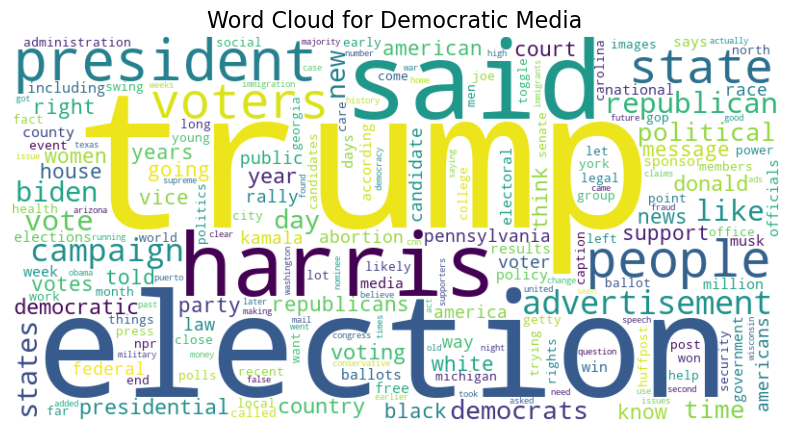

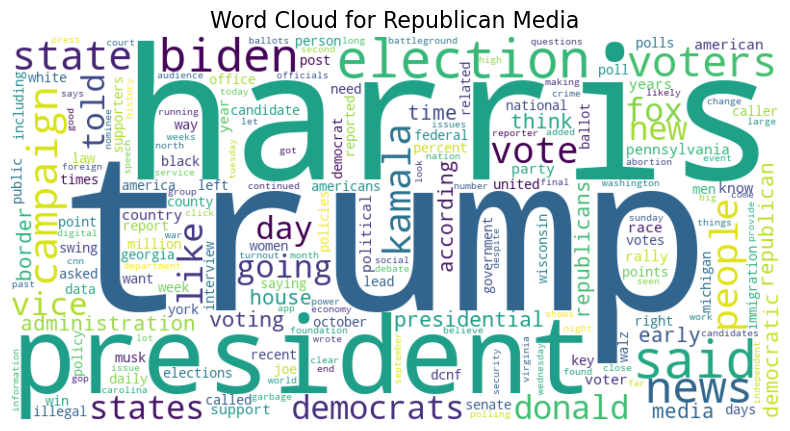

In [ ]:
def generate_word_cloud(word_counts, title):
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_counts)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(title, fontsize=16)
    plt.axis('off')
    plt.show()


generate_word_cloud(democratic_tf, "Word Cloud for Democratic Media")
generate_word_cloud(republican_tf, "Word Cloud for Republican Media")

## TD-IDF

In [ ]:
#custom_stopwords = [
#    "trump", "biden", "campaign", "election", 
#    "state", "people", "new", "year", "said","president","harris","advertisement","kamala","voters","new","like","news","votes","day","vote"
#]

corpus = [" ".join(democratic_tokens), " ".join(republican_tokens)]

#vectorizer = TfidfVectorizer(max_features=100, stop_words=custom_stopwords)
vectorizer = TfidfVectorizer(max_features=100)
tfidf_matrix = vectorizer.fit_transform(corpus)
tfidf_words = vectorizer.get_feature_names_out()

# Extract top TF-IDF words for each category
democratic_tfidf = tfidf_matrix[0].toarray().flatten()
republican_tfidf = tfidf_matrix[1].toarray().flatten()

democratic_tfidf_scores = dict(zip(tfidf_words, democratic_tfidf))
republican_tfidf_scores = dict(zip(tfidf_words, republican_tfidf))

print("\nTop TF-IDF words for Democratic Media:")
print(sorted(democratic_tfidf_scores.items(), key=lambda x: x[1], reverse=True)[:10])

print("\nTop TF-IDF words for Republican Media:")
print(sorted(republican_tfidf_scores.items(), key=lambda x: x[1], reverse=True)[:10])



Top TF-IDF words for Democratic Media:
[('trump', 0.5871919953645903), ('election', 0.2906502184413357), ('said', 0.2845131783560034), ('harris', 0.2723618389870456), ('president', 0.20019024758353823), ('people', 0.15821289339986558), ('voters', 0.14851637006504062), ('state', 0.1429930339882416), ('advertisement', 0.14102918116093527), ('campaign', 0.13403295546365648)]

Top TF-IDF words for Republican Media:
[('trump', 0.534986788578777), ('harris', 0.4095247946547713), ('president', 0.2676596425145528), ('election', 0.2283142292256641), ('said', 0.21955848936701), ('biden', 0.17422813997220582), ('news', 0.16358825356168943), ('voters', 0.1438601308421903), ('campaign', 0.14031350203868484), ('state', 0.132222755080688)]


                     Word #1            Word #2        Word #3  \
Democratic   jeffries (3.45)       slate (3.40)   penny (3.32)   
Republican  guideline (3.99)  partnering (3.98)  byline (3.97)   

                     Word #4             Word #5          Word #6  \
Democratic       kirk (3.28)       navajo (3.27)  baseless (3.25)   
Republican  licensing (3.97)  republished (3.96)  newswire (3.96)   

                        Word #7         Word #8          Word #9      Word #10  
Democratic  insurrection (3.21)   peanut (3.21)  medicaid (3.21)  tribe (3.18)  
Republican    federalist (3.91)  ranking (3.55)     enten (3.54)  bream (3.51)  


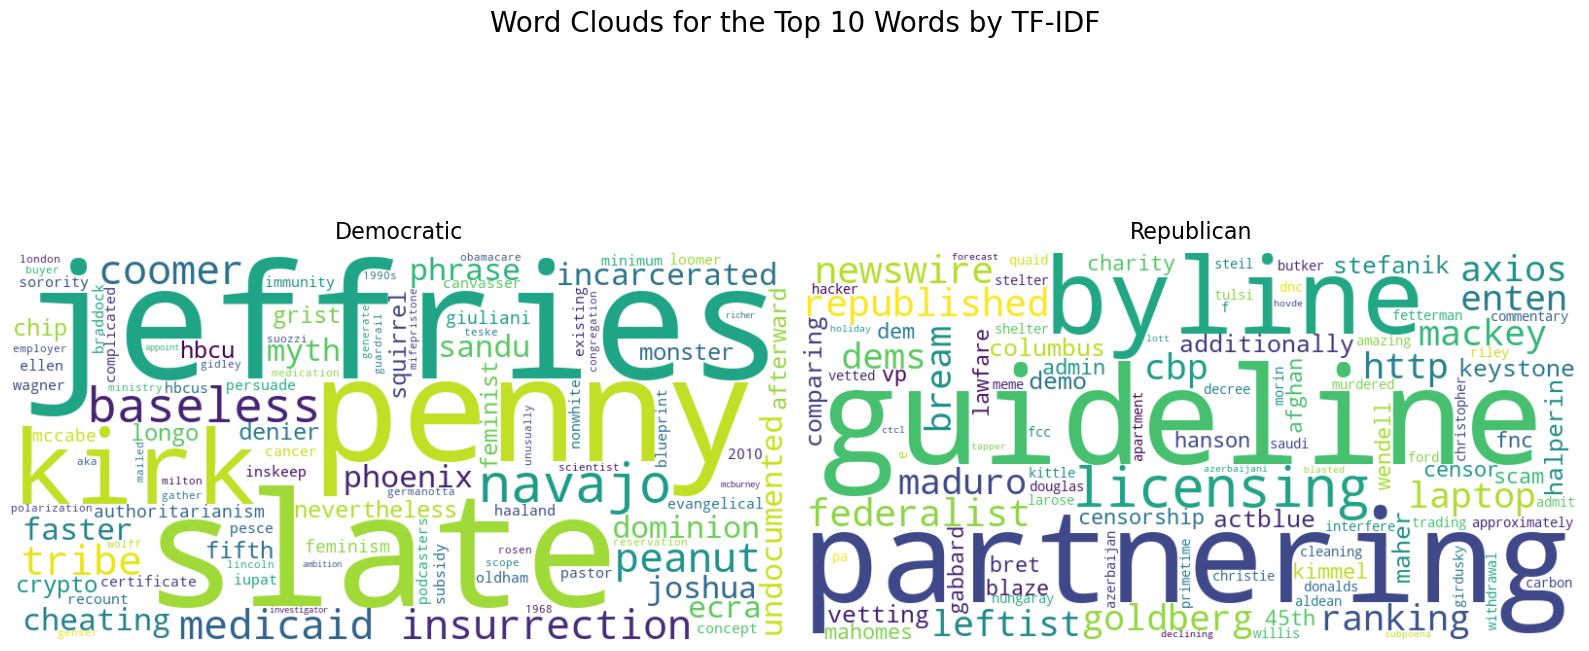

In [ ]:
manual_removals ={"toggle","huffpost","log","loading","getty","caller","dncf","breitbart","realclearpolitics","moldova","abate","hang","bow","maricopa","dcnf"}

stop_words = set(stopwords.words("english"))
lemmatizer = WordNetLemmatizer()


def preprocess_text(text):
    tokens = word_tokenize(text)
    tokens = [word.lower() for word in tokens if word.isalnum()]
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
    
    tokens = [word for word in tokens if word not in manual_removals]
    return tokens

# Aggregate text and build TF list for each media type
def aggregate_tf_for_media(media_name, media_files):
    media_text = ""
    for file_path in media_files:
        if os.path.exists(file_path):
            with open(file_path, 'r', encoding='utf-8') as file:
                media_text += file.read() + " "
    
    tokens = preprocess_text(media_text)
    tf_list = Counter(tokens)
    
    # Filter rare words
    tf_list_filtered = {word: count for word, count in tf_list.items() if count >= 5}
    return tf_list_filtered

# Save TF list for each media type
def save_tf_list(media_name, tf_list, output_folder):
    file_path = os.path.join(output_folder, f'{media_name}_tf_list.txt')
    with open(file_path, 'w', encoding='utf-8') as file:
        for word, count in tf_list.items():
            file.write(f"{word} {count}\n")


democratic_files = ["democratic_media_text.txt"]
republican_files = ["republican_media_text.txt"]

output_folder = 'tf_lists'
os.makedirs(output_folder, exist_ok=True)

# Generate and save TF lists
democratic_tf_list = aggregate_tf_for_media("democratic", democratic_files)
save_tf_list("democratic", democratic_tf_list, output_folder)

republican_tf_list = aggregate_tf_for_media("republican", republican_files)
save_tf_list("republican", republican_tf_list, output_folder)

# Load TF lists and calculate TF-IDF
media_files = ['democratic', 'republican']
tf_by_media = {}

for media_name in media_files:
    filename = os.path.join(output_folder, f'{media_name}_tf_list.txt')
    tf_dict = {}
    with open(filename, 'r', encoding='utf-8') as f:
        for line in f:
            word, count = line.strip().split()
            tf_dict[word] = 1 + math.log(int(count)) 
    tf_by_media[media_name] = tf_dict

# Calculate IDF across all media types
total_documents = len(tf_by_media)
df_counts = Counter()
for tf_dict in tf_by_media.values():
    unique_words = set(tf_dict.keys())
    for word in unique_words:
        df_counts[word] += 1

idf = {word: math.log(total_documents / df_count) for word, df_count in df_counts.items()}

# Calculate TF-IDF
tfidf_by_media = {}
for media_name, tf_values in tf_by_media.items():
    tfidf_by_media[media_name] = {word: tf * idf[word] for word, tf in tf_values.items()}

# Get top 10 TF-IDF words for each media type
top_words_by_media = {}
for media_name, tfidf in tfidf_by_media.items():
    sorted_tfidf = sorted(tfidf.items(), key=lambda x: x[1], reverse=True)
    top_words = sorted_tfidf[:10]
    top_words_by_media[media_name] = top_words

# Display results
table_data = []
for media_name, words in top_words_by_media.items():
    words = [f"{word} ({score:.2f})" for word, score in words]
    table_data.append(words)
df = pd.DataFrame(table_data, index=[media.title() for media in top_words_by_media],
                  columns=[f"Word #{i+1}" for i in range(10)])
print(df)

# Word clouds
fig, axes = plt.subplots(1, 2, figsize=(16, 8))
media_names = list(tfidf_by_media.keys())

for idx, media_name in enumerate(media_names):
    ax = axes[idx]
    top_tfidf_scores = dict(sorted(tfidf_by_media[media_name].items(), key=lambda x: x[1], reverse=True)[:100])
    wordcloud = WordCloud(width=800, height=400, background_color='white', collocations=False)
    wordcloud.generate_from_frequencies(top_tfidf_scores)
    ax.imshow(wordcloud, interpolation='bilinear')
    ax.axis('off')
    ax.set_title(media_name.title(), fontsize=16, pad=10)

plt.suptitle('Word Clouds for the Top 10 Words by TF-IDF', fontsize=20, y=1.02)
plt.tight_layout()
plt.show()


In [ ]:
# Load spaCy model
nlp = spacy.load("en_core_web_sm")

democratic_text_file = "democratic_cleaned_text.txt"
republican_text_file = "republican_cleaned_text.txt"

# Load text files
def load_text(file_path):
    with open(file_path, 'r', encoding='utf-8') as f:
        return f.read()

democratic_text = load_text(democratic_text_file)
republican_text = load_text(republican_text_file)

nlp.max_length = len(democratic_text) + 1000 

# Tokenization and cleaning
def clean_and_tokenize(text):
    doc = nlp(text)
    tokens = [
        token.text.lower() for token in doc
        if token.is_alpha and not token.is_stop
    ]
    return tokens

democratic_tokens = clean_and_tokenize(democratic_text)
republican_tokens = clean_and_tokenize(republican_text)

# Save token counts
democratic_tf = Counter(democratic_tokens)
republican_tf = Counter(republican_tokens)

# Display top 15 words
print("Top words in Democratic Media:")
print(democratic_tf.most_common(15))

print("\nTop words in Republican Media:")
print(republican_tf.most_common(15))


Top words in Democratic Media:
[('election', 2605), ('state', 1793), ('vote', 1593), ('voter', 1576), ('s', 1355), ('people', 1288), ('campaign', 1243), ('advertisement', 1156), ('year', 1069), ('day', 984), ('republican', 937), ('like', 915), ('win', 788), ('tell', 743), ('new', 734)]

Top words in Republican Media:
[('election', 2297), ('voter', 1779), ('state', 1774), ('vote', 1549), ('news', 1452), ('campaign', 1435), ('s', 1241), ('people', 1023), ('day', 992), ('tell', 921), ('year', 856), ('like', 848), ('win', 804), ('fox', 773), ('time', 765)]


## Computing Sentiments

This code uses a pre-trained BERT transformer model to analyze the sentiment of mentions of various politicians in articles. It uses the 'nlptown/bert-base-multilingual-uncased-sentiment' model to extract sentiment scores for mentions of politicians, which helps provide insights into the sentiment trends around their coverage.

The get_sentiment_score function takes a text string, tokenizes it, and uses the BERT model to predict its sentiment. Higher values indicate more positive sentiment.

In [ ]:
# Load the tokenizer and model
tokenizer = AutoTokenizer.from_pretrained('nlptown/bert-base-multilingual-uncased-sentiment')
model = AutoModelForSequenceClassification.from_pretrained('nlptown/bert-base-multilingual-uncased-sentiment')

# Move model to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

def get_sentiment_score(text):
    if not isinstance(text, str):
        return 3

    inputs = tokenizer.encode_plus(
        text,
        return_tensors='pt',
        truncation=True,
        max_length=512,
        padding='max_length'
    )

    inputs = {key: val.to(device) for key, val in inputs.items()}

    with torch.no_grad():
        outputs = model(**inputs)

    logits = outputs.logits
    probabilities = torch.softmax(logits, dim=1)
    predicted_class = torch.argmax(probabilities, dim=1).item()

    sentiment_rating = predicted_class + 1

    return sentiment_rating

For each mention of a politician, a context window (20 words before and after the mention) is extracted to capture the surrounding sentiment. The combined context for each politician is passed to the sentiment function to compute the sentiment score.

Sentiment scores are saved to a file (politician_sentiment_scores.pkl) for future reuse.

In [ ]:
politician_sentiment_scores_file = "politician_sentiment_scores.pkl"

# Check if the sentiment scores are already saved
if os.path.exists(politician_sentiment_scores_file):
    with open(politician_sentiment_scores_file, "rb") as f:
        sentiment_scores = pickle.load(f)
    print("Loaded politician sentiment scores from file.")
else:
    print("Computing politician sentiment scores...")

    # Build PhraseMatcher to find politician mentions
    matcher = PhraseMatcher(nlp.vocab, attr='LOWER')

    # Add patterns to the matcher for each politician's aliases
    for politician, aliases in politician_aliases_raw.items():
        patterns = [nlp.make_doc(alias.lower()) for alias in aliases]
        matcher.add(politician, patterns)

    sentiment_scores = {}

    # Iterate over articles
    for idx, content in tqdm(data_full_content['full_content'].items(), desc="Computing sentiment scores"):
        if not isinstance(content, str):
            continue

        doc = nlp(content)
        matches = matcher(doc)

        # Dictionary to store contexts
        politician_contexts = {}

        for match_id, start, end in matches:
            politician = nlp.vocab.strings[match_id]

            # Ensure the politician is actually mentioned in this article
            if politician not in article_mentions.get(idx, set()):
                continue

            if politician not in politician_contexts:
                politician_contexts[politician] = []

            # Extract 20 words before and after the mention
            start_context = max(0, start - 20)
            end_context = min(len(doc), end + 20)
            context_tokens = doc[start_context:end_context]
            context_text = context_tokens.text

            politician_contexts[politician].append(context_text)

        # Compute sentiment scores for each politician in the article
        for politician, contexts in politician_contexts.items():
            combined_context = ' '.join(contexts)
            sentiment_score = get_sentiment_score(combined_context)
            sentiment_scores[(idx, politician)] = sentiment_score

    # Save
    with open(politician_sentiment_scores_file, "wb") as f:
        pickle.dump(sentiment_scores, f)
    print("Politician sentiment scores computed and saved.")

Loaded politician sentiment scores from file.


### Average Sentiment Based on Party Affiliations Towards Top Politicians

In [37]:

# Define media outlet categories
democratic_outlets = [
    "cnn", "msnbc", "new york times", "nyt", "npr", "guardian", "huffpost", "huffington post",
    "slate", "vox", "politico", "buzzfeed", "buzzfeed news"
]
republican_outlets = [
    "fox news", "fox", "breitbart", "wall street journal", "wsj", "washington times",
    "national review", "daily caller", "blaze", "newsmax", "federalist", "oann",
    "one america news network"
]

**Function to map media source names to media categories:**

In [38]:
# Function to map source names to media categories
def get_media_category(source):
    source = str(source).strip().lower()
    # Remove common prefixes and suffixes
    source = re.sub(r'^(the|www\.)\s+', '', source)
    source = re.sub(r'\.com$', '', source)
    source = source.replace('-', ' ')
    source = source.replace('.', ' ')
    source = source.replace(',', '')
    
    # Check for democratic media
    for pattern in democratic_outlets:
        if pattern in source:
            return 'Democratic Media'
    
    # Check for republican media
    for pattern in republican_outlets:
        if pattern in source:
            return 'Republican Media'
    
    return None  # Unknown media category

**Creating dataframes for visualisation:**

In [39]:
# Initialize dictionaries to store mention counts and sentiments
media_politician_data = defaultdict(lambda: defaultdict(list))

# Loop through articles
for idx, row in tqdm(data_full_content.iterrows(), total=data_full_content.shape[0], desc="Processing Articles"):
    source = row['source']
    article_date = row['published_at']
    media_category = get_media_category(source)
    
    if not media_category:
        continue  # Skip articles without a known media category
    
    mentioned_politicians = article_mentions.get(idx, set())
    
    for politician in mentioned_politicians:
        # Get the sentiment score for this politician in this article
        sentiment = sentiment_scores.get((idx, politician), 3)  # Default to neutral if not found
        
        # Append sentiment to the list for this media category and politician
        media_politician_data[media_category][politician].append(sentiment)


Processing Articles: 100%|██████████| 7556/7556 [00:00<00:00, 51266.05it/s]


In [40]:
def create_media_politician_df(media_category):
    data = []
    for politician, sentiments in media_politician_data[media_category].items():
        mention_count = len(sentiments)
        average_sentiment = sum(sentiments) / mention_count
        data.append({
            'politician': politician,
            'mention_count': mention_count,
            'average_sentiment': average_sentiment
        })
    df = pd.DataFrame(data)
    return df

In [41]:
# Republican Media
republican_df = create_media_politician_df('Republican Media')

# Democratic Media
democratic_df = create_media_politician_df('Democratic Media')


**Define top politicians based on mentions::**

In [42]:
top_n = 10

# Republican Media
top_politicians_republican = republican_df.sort_values(by='mention_count', ascending=False).head(top_n)

# Democratic Media
top_politicians_democratic = democratic_df.sort_values(by='mention_count', ascending=False).head(top_n)


**Assign colours based on party:**

In [43]:
# Assign colors for Republican Media
colors_republican = []
for politician in top_politicians_republican['politician']:
    if politician in republican_politicians:
        colors_republican.append('red')
    elif politician in democratic_politicians:
        colors_republican.append('blue')
    else:
        colors_republican.append('gray')  # For other or unknown politicians

# Assign colors for Democratic Media
colors_democratic = []
for politician in top_politicians_democratic['politician']:
    if politician in republican_politicians:
        colors_democratic.append('red')
    elif politician in democratic_politicians:
        colors_democratic.append('blue')
    else:
        colors_democratic.append('gray')

**Plotting the sentiments:**

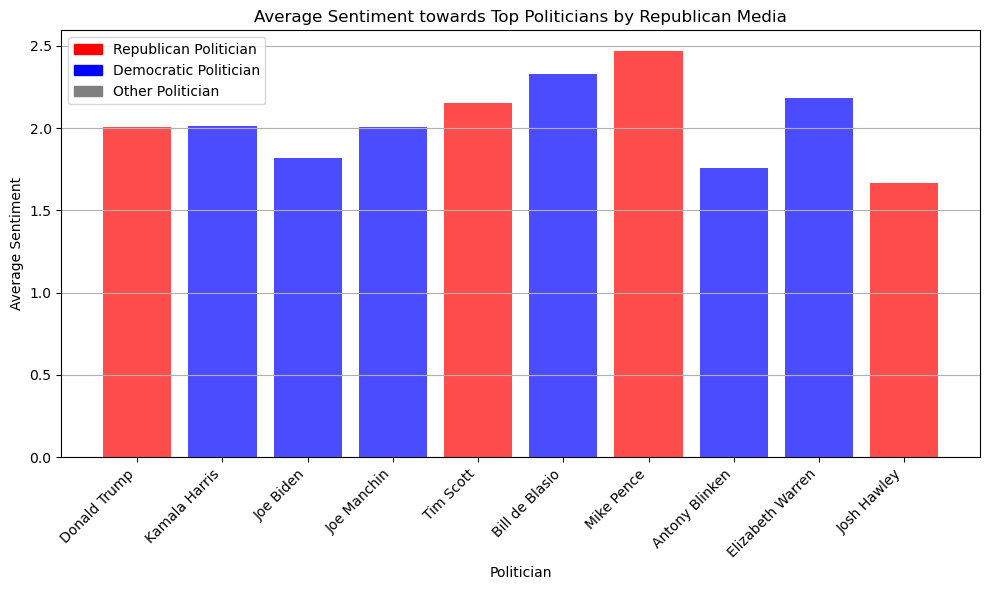

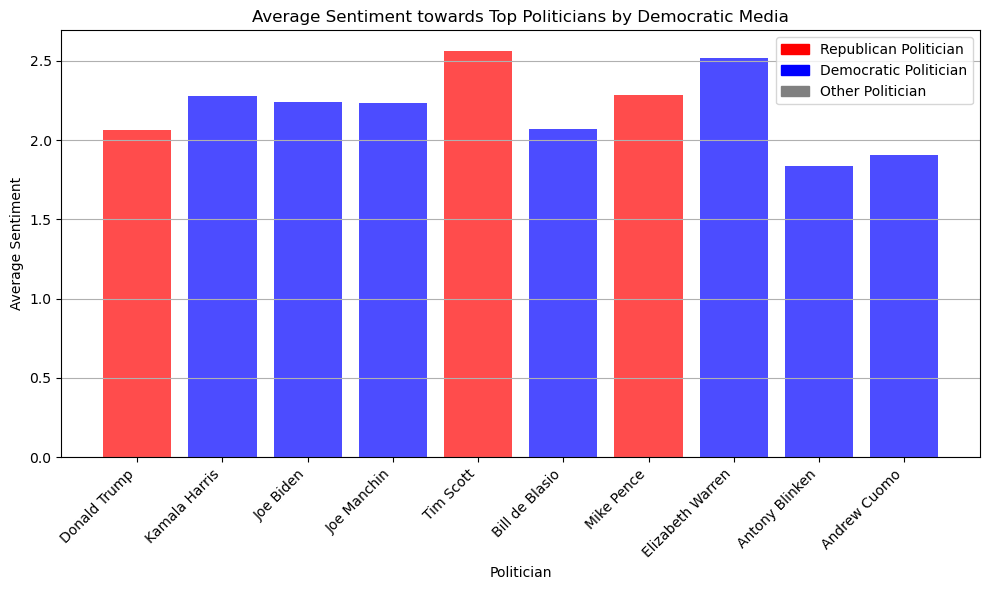

In [44]:
plt.figure(figsize=(10, 6))
plt.bar(top_politicians_republican['politician'], top_politicians_republican['average_sentiment'], color=colors_republican, alpha=0.7)
plt.xlabel('Politician')
plt.ylabel('Average Sentiment')
plt.title('Average Sentiment towards Top Politicians by Republican Media')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.grid(axis='y')

# Add a legend
red_patch = mpatches.Patch(color='red', label='Republican Politician')
blue_patch = mpatches.Patch(color='blue', label='Democratic Politician')
gray_patch = mpatches.Patch(color='gray', label='Other Politician')
plt.legend(handles=[red_patch, blue_patch, gray_patch])

plt.show()

# Plotting Average Sentiment Towards Top Politicians by Democratic Media
plt.figure(figsize=(10, 6))
plt.bar(top_politicians_democratic['politician'], top_politicians_democratic['average_sentiment'], color=colors_democratic, alpha=0.7)
plt.xlabel('Politician')
plt.ylabel('Average Sentiment')
plt.title('Average Sentiment towards Top Politicians by Democratic Media')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.grid(axis='y')

# Add a legend
plt.legend(handles=[red_patch, blue_patch, gray_patch])

plt.show()

**Average sentiment based on media outlet:**

Processing Articles: 100%|██████████| 7556/7556 [00:00<00:00, 57211.23it/s]
/var/folders/tj/czw2xwdj6jv1gvfb9pcj33sh0000gn/T/ipykernel_3835/3869753323.py:56: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  media_sentiment = media_politician_df.groupby('media').apply(


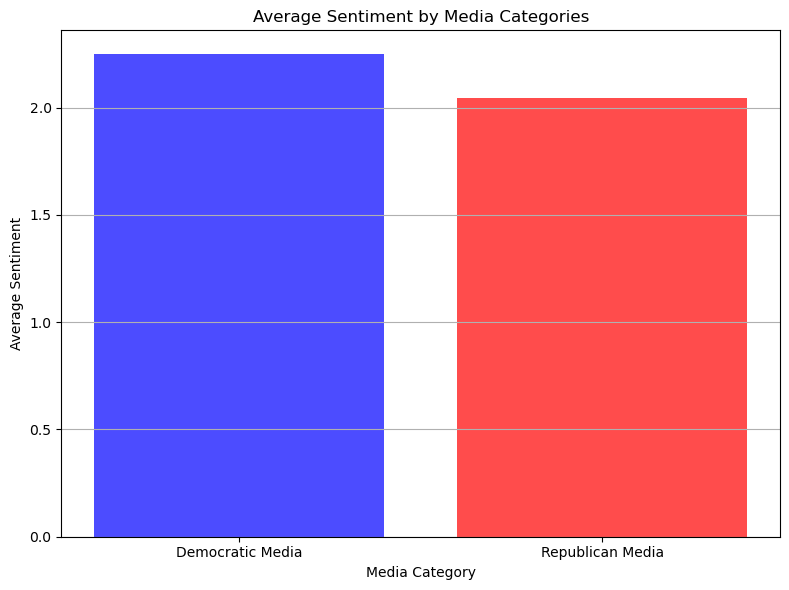

In [45]:
def get_media_category(source):
    source = str(source).strip().lower()
    # Remove common prefixes and suffixes
    source = re.sub(r'^(the|www\.)\s+', '', source)
    source = re.sub(r'\.com$', '', source)
    source = source.replace('-', ' ')
    source = source.replace('.', ' ')
    source = source.replace(',', '')
    
    # Check for democratic media
    for pattern in democratic_outlets:
        if pattern in source:
            return 'Democratic Media'
    
    # Check for republican media
    for pattern in republican_outlets:
        if pattern in source:
            return 'Republican Media'
    
    return None  # Unknown media category

# list to hold mentions
edge_data = []

for idx, row in tqdm(data_full_content.iterrows(), total=data_full_content.shape[0], desc="Processing Articles"):
    source = row['source']
    media_category = get_media_category(source)
    if not media_category:
        continue  # Skip articles without a known media category

    mentioned_politicians = article_mentions.get(idx, set())
    for politician in mentioned_politicians:
        # Get the sentiment score for this politician in this article
        sentiment = sentiment_scores.get((idx, politician), 3)  # Default to neutral
        edge_data.append({
            'media': media_category,
            'politician': politician,
            'sentiment_score': sentiment
        })

edge_df = pd.DataFrame(edge_data)

# Compute mention counts and average sentiments
grouped = edge_df.groupby(['media', 'politician'])

# Compute mention counts
mention_counts = grouped['sentiment_score'].count().reset_index(name='mention_count')

# Compute average sentiments
average_sentiments = grouped['sentiment_score'].mean().reset_index(name='average_sentiment')

# Merge mention counts and average sentiments
media_politician_df = pd.merge(mention_counts, average_sentiments, on=['media', 'politician'])

# Compute weighted average sentiment per media category
media_sentiment = media_politician_df.groupby('media').apply(
    lambda x: np.average(x['average_sentiment'], weights=x['mention_count'])
).reset_index(name='weighted_average_sentiment')

# Plot
plt.figure(figsize=(8, 6))
colors = ['blue' if media == 'Democratic Media' else 'red' for media in media_sentiment['media']]
plt.bar(media_sentiment['media'], media_sentiment['weighted_average_sentiment'], color=colors, alpha=0.7)
plt.xlabel('Media Category')
plt.ylabel('Average Sentiment')
plt.title('Average Sentiment by Media Categories')
plt.xticks(rotation=0)
plt.tight_layout()
plt.grid(axis='y')
plt.show()


# **Network Construction and Analysis**

Loading graph for the politician network: Here we load the graph we created praviously and saved in the project as "politician_mention_graph.graphml"

In [46]:
# Path to the graph
graph_file = "politician_mention_graph.graphml"

if os.path.exists(graph_file):
    G = nx.read_graphml(graph_file)
    print("Loaded graph G from file.")
else:
    G = nx.Graph()
    
    # Add nodes with attributes (politicians and articles)
    for politician, articles in politician_mentions.items():
        G.add_node(politician, articles=list(articles))
    
    # Add edges based on which politicians are mentioned in the same articles
    for article_idx, mentioned_politicians in article_mentions.items():
        mentioned_politicians = list(mentioned_politicians)
        for i in range(len(mentioned_politicians)):
            for j in range(i + 1, len(mentioned_politicians)):
                p1, p2 = mentioned_politicians[i], mentioned_politicians[j]
                if G.has_edge(p1, p2):
                    G[p1][p2]['weight'] += 1
                else:
                    G.add_edge(p1, p2, weight=1)
                    
    for node, data in G.nodes(data=True):
        data['articles'] = ",".join(map(str, data['articles']))
    nx.write_graphml(G, graph_file)
    print("Graph G created and saved.")

Loaded graph G from file.


# **Network Attributes**

Simple display of the most important attributes of our network.

In [79]:
# Output graph information
print(f"Number of nodes: {G.number_of_nodes()}")
print(f"Number of edges: {G.number_of_edges()}")
print("Sample edges with weights:")
for u, v, attrs in list(G.edges(data=True))[:5]:
    print(f"{u} - {v}: {attrs}")

Number of nodes: 256
Number of edges: 4013
Sample edges with weights:
Donald Trump - Tim Scott: {'weight': 977}
Donald Trump - Kamala Harris: {'weight': 5181}
Donald Trump - Ruben Gallego: {'weight': 35}
Donald Trump - Susie Lee: {'weight': 3}
Donald Trump - Joe Biden: {'weight': 3400}


# **Network Display**

Visual display of the netwrok, where nodes are politicians, edges are made between politicians who are mentioned in the same article and the weight of the edge depends on how many times this pair of politicians are mentioned in different articles.

100%|██████████| 2000/2000 [00:01<00:00, 1772.30it/s]


BarnesHut Approximation  took  0.42  seconds
Repulsion forces  took  0.54  seconds
Gravitational forces  took  0.00  seconds
Attraction forces  took  0.04  seconds
AdjustSpeedAndApplyForces step  took  0.07  seconds


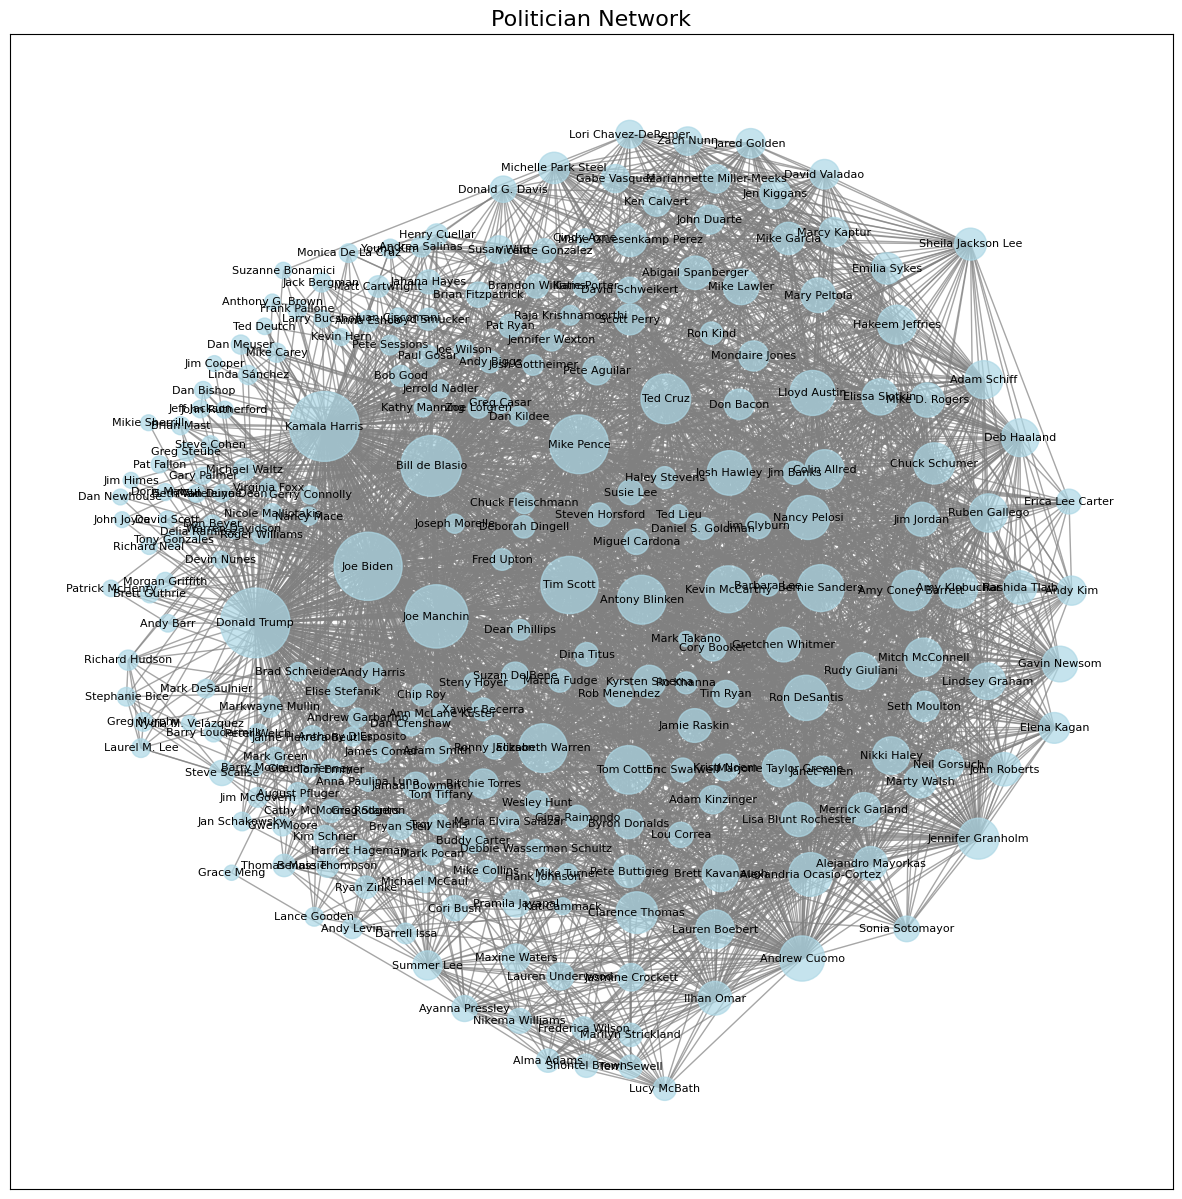

In [74]:
# We use ForceAtlas2
forceatlas2 = ForceAtlas2(
    jitterTolerance=1.0,  
    barnesHutOptimize=True,  
    barnesHutTheta=1.5, 
    scalingRatio=100.0,  
    strongGravityMode=True,  
    gravity=0.01,  
    verbose=True 
)

positions = forceatlas2.forceatlas2_networkx_layout(G, iterations=2000)

# Adjust node sizes based on degree
node_sizes = [100 + 10 * G.degree(n) for n in G.nodes()]

# Display
plt.figure(figsize=(15, 15)) 
nx.draw_networkx(
    G,
    pos=positions,
    with_labels=False,  
    node_size=node_sizes,  
    node_color='lightblue',  
    edge_color='gray',  
    alpha=0.7  
)

# Center the text over the nodes
for node, (x, y) in positions.items():
    plt.text(x, y, s=node, fontsize=8, ha='center', va='center', color='black')

plt.title("Politician Network", fontsize=16)
plt.show()


# **Network Display With Adjustments For Better Overiew**

The network is the same as previously, but here we used the 3 lists that we created previously to divide politicians into their correct affiliations (repuclicans = red, democrats = blue, other = grey). We only display the top most mentioned names here and have adjusted node sizes such that politicians that are mentioned much more than others, these nodes are much larger too. This should overall give a better overview of the most important things of the network.

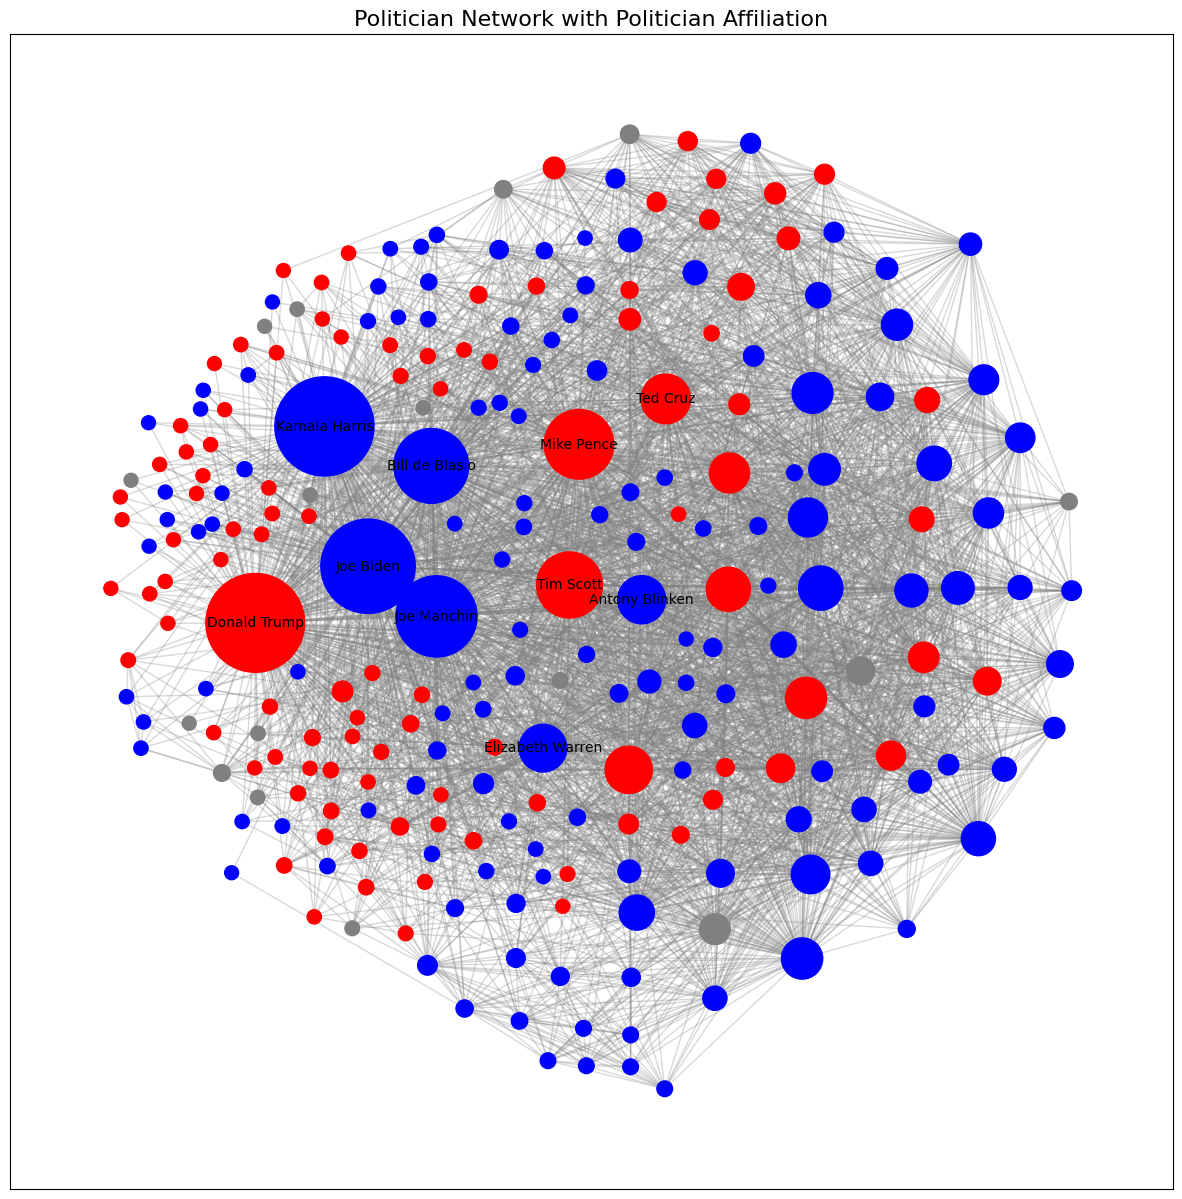

In [76]:
# Remove nodes not connected 
if not nx.is_connected(G):
    largest_cc = max(nx.connected_components(G), key=len)
    G = G.subgraph(largest_cc).copy()

node_degrees = dict(G.degree())
max_degree = max(node_degrees.values())

node_sizes = [100 + (deg / max_degree) ** 2 * 5000 for deg in node_degrees.values()]

# Assign node colors based on political affiliation
node_colors = [
    "red" if node in republican_politicians else 
    "blue" if node in democratic_politicians else 
    "grey"
    for node in G.nodes()
]

top_10_nodes = sorted(node_degrees.items(), key=itemgetter(1), reverse=True)[:10]
top_10_labels = {node: node for node, _ in top_10_nodes}

plt.figure(figsize=(15, 15))

nx.draw_networkx_edges(
    G,
    pos=positions,
    edge_color='gray',  
    alpha=0.3  
)

nx.draw_networkx_nodes(
    G,
    pos=positions,
    node_size=node_sizes,  
    node_color=node_colors,  
)

for node, (x, y) in positions.items():
    if node in top_10_labels:
        plt.text(x, y, s=top_10_labels[node], fontsize=10, ha='center', va='center', color='black')

plt.title("Politician Network with Politician Affiliation", fontsize=16)

# Display the graph
plt.show()


# **Degree Centrality**

Measures how many direct connections (edges) each node (politician) has. High degree centrality indicates frequently mentioned politicians.We can use this to identify key figures.

In [50]:
# Calculate degree centrality
degree_centrality = nx.degree_centrality(G)

top_degree = sorted(degree_centrality.items(), key=lambda x: x[1], reverse=True)
print("Top politicians by degree centrality:")
for politician, centrality in top_degree[:10]:
    print(f"{politician}: {centrality}")


Top politicians by degree centrality:
Kamala Harris: 0.94921875
Donald Trump: 0.9453125
Joe Biden: 0.90234375
Joe Manchin: 0.7734375
Bill de Blasio: 0.7109375
Mike Pence: 0.66015625
Tim Scott: 0.625
Ted Cruz: 0.4609375
Antony Blinken: 0.4453125
Elizabeth Warren: 0.44140625


#### Comment on Degree Centrality:

Kamala Harris and Donald Trump have the highest degree centrality, indicating that they are the most frequently mentioned figures in articles. This is expected as they are key figures in the 2024 U.S. Presidential Election. The degree centrality values for Kamala Harris (0.949) and Donald Trump (0.945) are very close, suggesting similar media prominence. 

The sitting president, Joe Biden's high centrality (0.902) indicates his significant presence in the media narrative, even if he’s not a primary candidate. 

Politicians like Joe Manchin (0.773), Bill de Blasio (0.710), Mike Pence (0.660) and Tim Scott (0.625) have high centrality, possibly due to their involvement in key issues and endorsements. 

# **Betweenness Centrality**

Measures how often a node lies on the shortest path between other nodes.
High betweenness suggests a politician acts as a bridge between different clusters or groups.

In [51]:
# Calculate betweenness centrality
betweenness_centrality = nx.betweenness_centrality(G, weight='weight')

top_betweenness = sorted(betweenness_centrality.items(), key=lambda x: x[1], reverse=True)
print("Top politicians by betweenness centrality:")
for politician, centrality in top_betweenness[:10]:
    print(f"{politician}: {centrality}")


Top politicians by betweenness centrality:
Bill de Blasio: 0.07259600498245664
Kamala Harris: 0.06482556068054192
Joe Biden: 0.057513502824853124
Donald Trump: 0.05493601749456324
Mike Pence: 0.0495253507174028
Joe Manchin: 0.04205014811552716
Tom Cotton: 0.03805073793415051
Antony Blinken: 0.03620505135606351
Ted Cruz: 0.0354092288776877
Tim Scott: 0.033483457233661584


### Comments on Betweenness Centrality:

Bill de Blasio leads with the highest betweenness centrality (0.0726), highlighting his role as a bridge between disconnected groups, despite lower overall prominence. This suggests his strategic importance in media narratives, potentially linking liberal and conservative figures. Kamala Harris (0.0648) and Joe Biden (0.0575) rank high. Donald Trump (0.0549) probably serves as a connector between polarized viewpoints, aligning with his central role in cross-party media narratives.


# **Clustering Coefficient**

Measures the likelihood that two neighbors of a node are also connected. Useful to assess the cohesiveness of politicians’ co-mentions.

In [52]:
# Calculate clustering coefficients
clustering = nx.clustering(G, weight='weight')

average_clustering = sum(clustering.values()) / len(clustering)
print(f"Average clustering coefficient: {average_clustering}")

top_clustering = sorted(clustering.items(), key=lambda x: x[1], reverse=True)
print("Top politicians by clustering coefficient:")
for politician, coef in top_clustering[:10]:
    print(f"{politician}: {coef}")

Average clustering coefficient: 0.0010829990478953676
Top politicians by clustering coefficient:
David Scott: 0.004330174791826802
Pat Fallon: 0.0037578239156388395
Steve Cohen: 0.003193626698765247
Dan Newhouse: 0.003035669074363347
John Joyce: 0.003035669074363347
Jim Himes: 0.003035669074363347
María Elvira Salazar: 0.0030135014456676118
Barry Moore: 0.002654435532085133
Gary Palmer: 0.002506421239423402
Madeleine Dean: 0.002421259483702012


#### Comments on Clustering Coefficient:

The average clustering coefficient is very low (0.00108), indicating sparse local groupings and a lack of tightly interconnected clusters in the media narrative. Top figures like David Scott (0.00433) and Pat Fallon (0.00376) show minimal clustering, reflecting dispersed mentions without cohesive networks.

# **Plotting degree distrubutions** 

Degree distrubutions provides insights into how nodes (politicians) are connected and can reveal patterns like whether the network exhibits a uniform, random, or power-law structure.

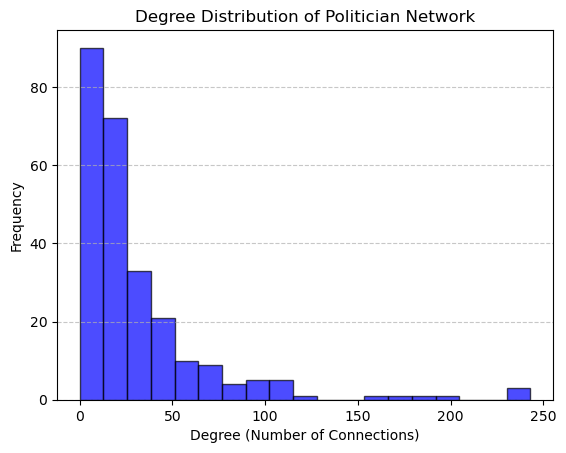

In [53]:
degrees = [degree for _, degree in G.degree()]
degree_counts = np.bincount(degrees)
unique_degrees = np.arange(len(degree_counts))

bins = np.linspace(min(degrees), max(degrees), num=20) 

counts, bin_edges = np.histogram(degrees, bins=bins)

bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

# Plot the degree distribution
plt.bar(bin_centers, counts, width=bin_centers[1] - bin_centers[0], color='blue', edgecolor='black', alpha=0.7)

plt.title("Degree Distribution of Politician Network")
plt.xlabel("Degree (Number of Connections)")
plt.ylabel("Frequency")
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()



#### Comment on the Degree Distribution Plot

The degree distribution plot reveals a right-skewed structure. The majority of politicians have a low degree (few connections). A small number of nodes have significantly higher degrees, indicating their prominence in media co-mentions (this would probably be people like Donald Trump, Kamala Harris and Joe Biden)

Plotting the degree distribution is a valuable step for analyzing the structure of your network. It provides insights into how nodes (politicians) are connected and can reveal patterns like whether the network exhibits a uniform, random, or power-law structure. In your project, understanding the degree distribution can help identify whether certain politicians dominate the narrative or if connections are evenly spread.

Calculating best minimal value for power law fit
Power-law fit alpha: 2.851722896219214
Power-law fit xmin: 44.0


Values less than or equal to 0 in data. Throwing out 0 or negative values


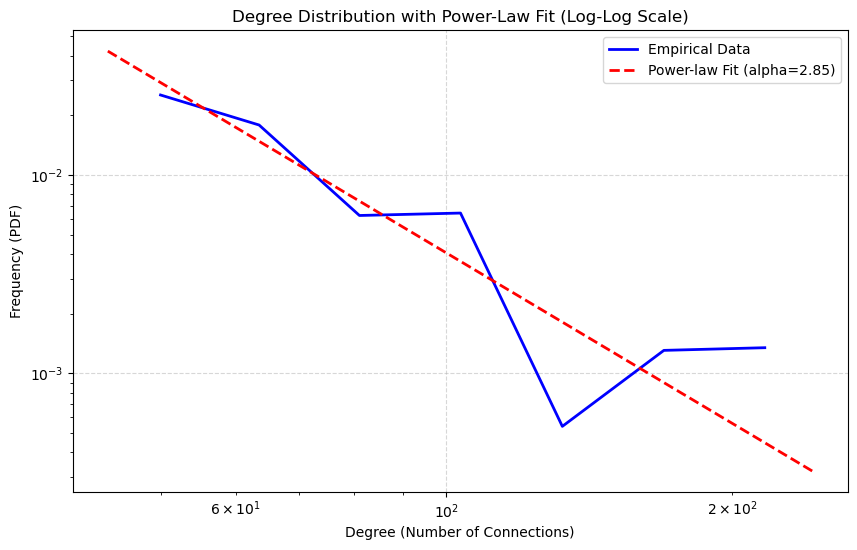

In [54]:
degrees = [degree for _, degree in G.degree()]

fit = powerlaw.Fit(degrees)

# Extract the estimated alpha (exponent) for the power-law distribution
alpha = fit.power_law.alpha
xmin = fit.power_law.xmin

# Display results
print(f"Power-law fit alpha: {alpha}")
print(f"Power-law fit xmin: {xmin}")

# Plot the degree distribution on a log-log scale with the power-law fit
plt.figure(figsize=(10, 6))
fit.plot_pdf(color='blue', linewidth=2, label='Empirical Data')
fit.power_law.plot_pdf(color='red', linestyle='--', linewidth=2, label=f'Power-law Fit (alpha={alpha:.2f})')

# Display
plt.title("Degree Distribution with Power-Law Fit (Log-Log Scale)")
plt.xlabel("Degree (Number of Connections)")
plt.ylabel("Frequency (PDF)")
plt.legend()
plt.grid(alpha=0.5, linestyle='--')
plt.show()


#### Comment on Degree Distribution with Power-Law Fit

The degree distribution follows a power law pattern for degrees above the threshold, as indicated by the red dashed line. This result highlights the dominance of highly connected nodes in the network, supporting the hypothesis that media coverage is concentrated around a few key politicians.


# **Compare with a Simulated Barabasi-Albert (BA) Network**

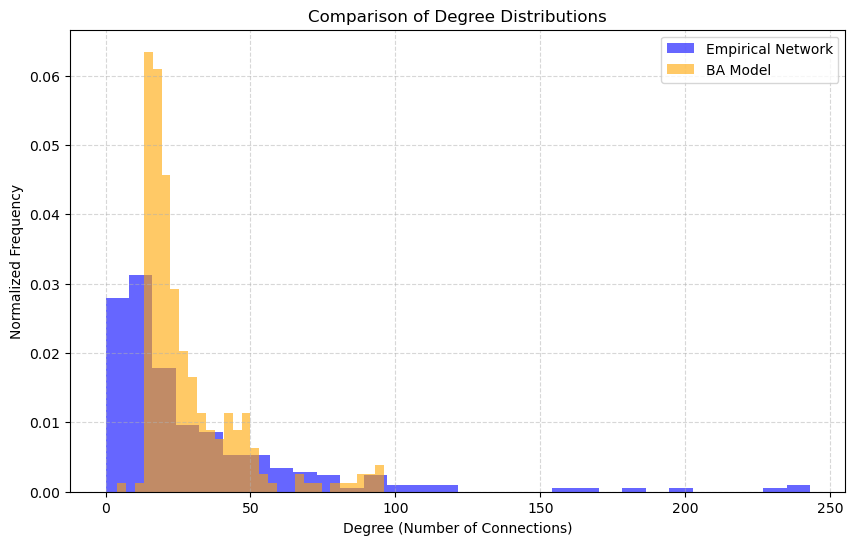

In [55]:
N = len(G.nodes) 
m = int(np.mean(degrees) / 2)  
ba_network = nx.barabasi_albert_graph(N, m)

ba_degrees = [degree for _, degree in ba_network.degree()]
plt.figure(figsize=(10, 6))
plt.hist(degrees, bins=30, density=True, alpha=0.6, label="Empirical Network", color='blue')
plt.hist(ba_degrees, bins=30, density=True, alpha=0.6, label="BA Model", color='orange')

# Display
plt.title("Comparison of Degree Distributions")
plt.xlabel("Degree (Number of Connections)")
plt.ylabel("Normalized Frequency")
plt.legend()
plt.grid(alpha=0.5, linestyle='--')
plt.show()


#### Comment on Comparison with BA Model

The degree distribution of the politician network (blue) and the BA model (orange) show similar overall trends, particularly in the tail of the distribution, where both exhibit a long-tailed structure.

# **Advanced Centrality Measures**

In [56]:
# Calculate Betweenness Centrality
betweenness = nx.betweenness_centrality(G, normalized=True, weight='weight')

# Calculate Eigenvector Centrality
eigenvector = nx.eigenvector_centrality(G, max_iter=1000, weight='weight')

# Find the top 5 nodes for each measure
top_betweenness = sorted(betweenness.items(), key=lambda x: x[1], reverse=True)[:5]
top_eigenvector = sorted(eigenvector.items(), key=lambda x: x[1], reverse=True)[:5]

# Display
print("Top 5 Nodes by Betweenness Centrality:")
for node, value in top_betweenness:
    print(f"{node}: {value:.4f}")

print("\nTop 5 Nodes by Eigenvector Centrality:")
for node, value in top_eigenvector:
    print(f"{node}: {value:.4f}")


Top 5 Nodes by Betweenness Centrality:
Bill de Blasio: 0.0726
Kamala Harris: 0.0648
Joe Biden: 0.0575
Donald Trump: 0.0549
Mike Pence: 0.0495

Top 5 Nodes by Eigenvector Centrality:
Donald Trump: 0.5420
Kamala Harris: 0.5338
Joe Biden: 0.4559
Joe Manchin: 0.3721
Tim Scott: 0.1507


#### Comments on Analysis of Top Centrality Measures

Figures like Donald Trump, Kamala Harris, and Joe Biden rank highly in both measures, indicating their central importance in the network, both as hubs and as connectors.
   
Betweenness Centrality emphasizes bridging roles for example Bill de Blasio, while Eigenvector Centrality highlights influence through strong connections to other prominent nodes for example Donald Trump.

# **Scatter Plot**

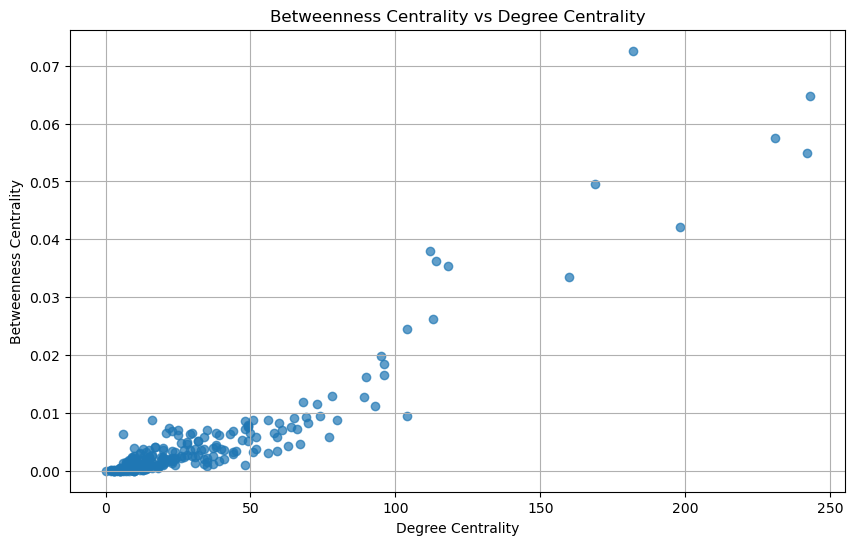

In [57]:
# Create scatter plot
betweenness_values = list(betweenness.values())
degree_values = [G.degree[node] for node in G.nodes()]

plt.figure(figsize=(10, 6))
plt.scatter(degree_values, betweenness_values, alpha=0.7)
plt.xlabel("Degree Centrality")
plt.ylabel("Betweenness Centrality")
plt.title("Betweenness Centrality vs Degree Centrality")
plt.grid(True)
plt.show()


#### Comment on Betweenness Centrality vs Degree Centrality Scatter Plot

The plot reveals a clear positive correlation between betweenness centrality and degree centrality. Nodes with higher degrees tend to have higher betweenness centrality, indicating that hubs (nodes with many connections) often act as bridges between different parts of the network.

# **Community Detection**

In [ ]:
# Perform community detection
partition = community_louvain.best_partition(G, weight='weight')

communities = defaultdict(list)
for politician, community_id in partition.items():
    communities[community_id].append(politician)

# Display communities
# for community_id, members in communities.items():
#     print(f"Community {community_id}: {members}")


In [59]:
# Calculate modularity score
modularity_score = community_louvain.modularity(partition, G, weight='weight')
print(f"Modularity Score: {modularity_score:.4f}")


Modularity Score: 0.0602


In [60]:
# Calculate the size of each community
community_sizes = {community_id: len(members) for community_id, members in communities.items()}

print("Community Sizes:")
for community_id, size in community_sizes.items():
    print(f"Community {community_id}: {size} members")


Community Sizes:
Community 6: 39 members
Community 1: 106 members
Community 2: 37 members
Community 3: 48 members
Community 4: 24 members
Community 0: 2 members
Community 5: 1 members


In [61]:
# Calculate intra- and inter-community edges
community_connectivity = {}
for community_id, members in communities.items():
    intra_edges = 0
    inter_edges = 0
    for node in members:
        for neighbor in G.neighbors(node):
            if partition[neighbor] == community_id:
                intra_edges += 1
            else:
                inter_edges += 1
    intra_edges = intra_edges / 2
    connectivity_score = intra_edges / (intra_edges + inter_edges) if intra_edges + inter_edges > 0 else 0
    community_connectivity[community_id] = connectivity_score

# Display connectivity scores
print("Community Connectivity Scores:")
for community_id, score in community_connectivity.items():
    print(f"Community {community_id}: {score:.4f}")


Community Connectivity Scores:
Community 6: 0.1272
Community 1: 0.4094
Community 2: 0.1522
Community 3: 0.2195
Community 4: 0.1068
Community 0: 0.0909
Community 5: 0.0000


In [62]:
# Calculate average degree for each community
average_degree = {}
for community_id, members in communities.items():
    avg_degree = sum(G.degree(node) for node in members) / len(members)
    average_degree[community_id] = avg_degree

# Display average degree
print("Average Degree per Community:")
for community_id, avg_degree in average_degree.items():
    print(f"Community {community_id}: {avg_degree:.2f}")



Average Degree per Community:
Community 6: 43.62
Community 1: 33.68
Community 2: 25.78
Community 3: 26.04
Community 4: 22.46
Community 0: 6.00
Community 5: 0.00


# **Plot Comunity Network**

Here we make the community netowrk, to see if the politicians will form any communities.

100%|██████████| 2000/2000 [00:01<00:00, 1223.00it/s]


BarnesHut Approximation  took  0.61  seconds
Repulsion forces  took  0.80  seconds
Gravitational forces  took  0.00  seconds
Attraction forces  took  0.06  seconds
AdjustSpeedAndApplyForces step  took  0.10  seconds


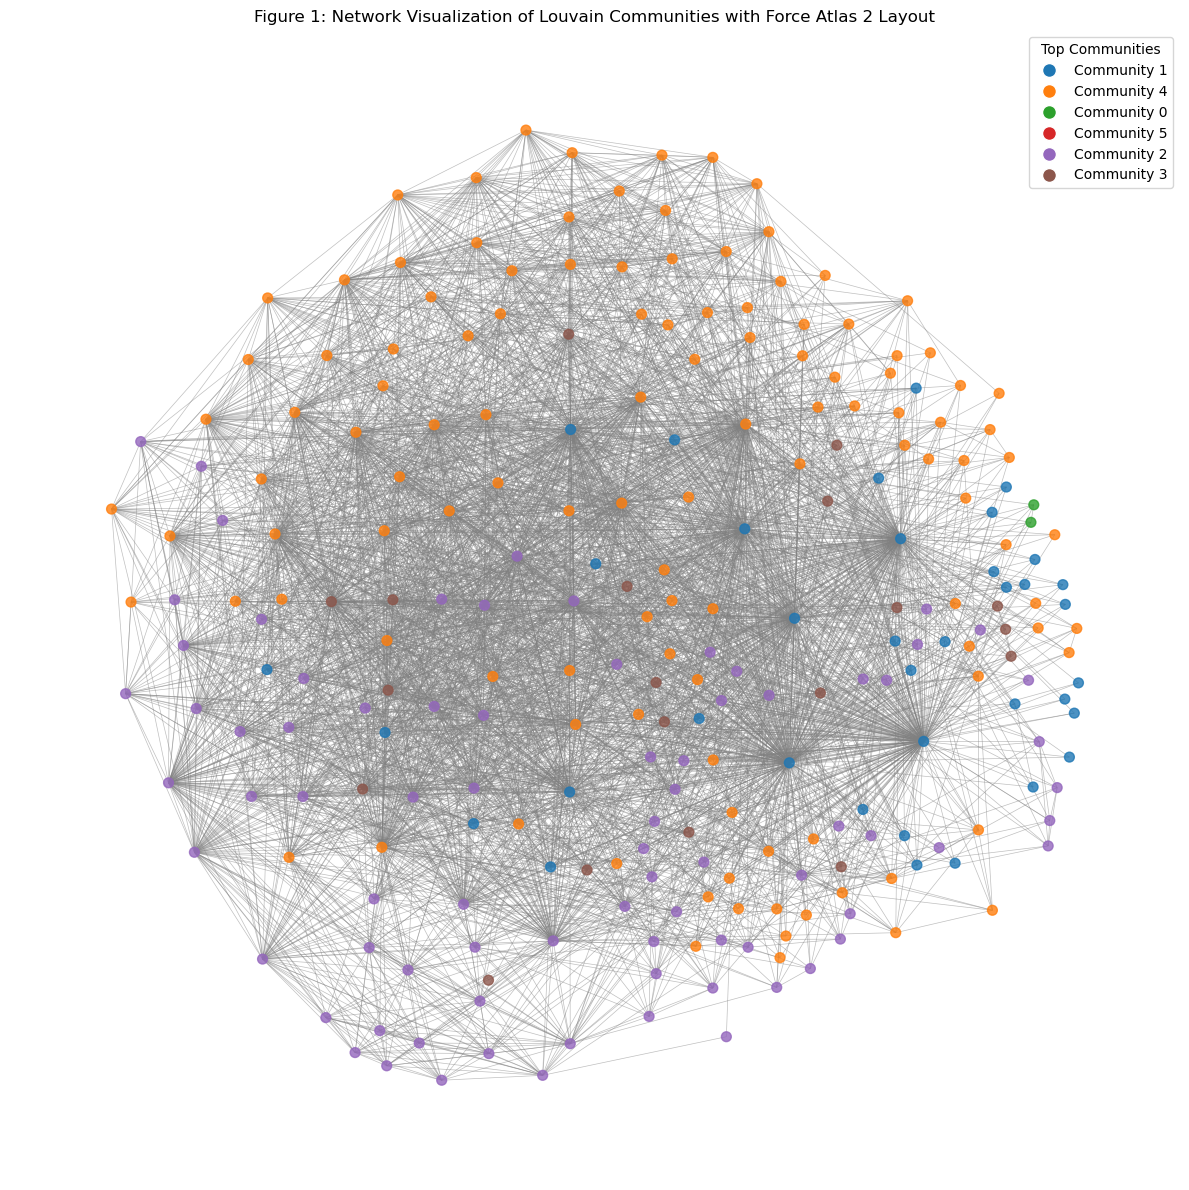

In [63]:
partition = community_louvain.best_partition(G)

community_sizes = Counter(partition.values())
sorted_communities = community_sizes.most_common()

isolated_nodes = list(nx.isolates(G))
G.remove_nodes_from(isolated_nodes)

G.remove_edges_from(nx.selfloop_edges(G))

top_communities = [community for community, size in sorted_communities[:10]]
color_map = plt.get_cmap('tab10')
node_colors = []

for node in G.nodes():
    community_id = partition[node]
    node_colors.append(color_map(community_id % 10) if community_id in top_communities else 'lightgray')

forceatlas2 = ForceAtlas2(
     outboundAttractionDistribution=False,
     linLogMode=False,
    adjustSizes=False,
    edgeWeightInfluence=1.0,
    jitterTolerance=1.0, 
    barnesHutOptimize=True, 
    barnesHutTheta=1.5,  
    scalingRatio=100.0,  
    strongGravityMode=True,  
    gravity=0.01,  
    verbose=True  
)
positions = forceatlas2.forceatlas2_networkx_layout(G, iterations=2000)

# Draw the network with community colors
plt.figure(figsize=(12, 12))
nx.draw_networkx_nodes(G, positions, node_size=50, node_color=node_colors, alpha=0.8)
nx.draw_networkx_edges(G, positions, edge_color='gray', alpha=0.5, width=0.5)
plt.axis("off")

# Create top communities
handles = [
    plt.Line2D([0], [0], marker='o', color='w', label=f"Community {community}",
               markerfacecolor=color_map(i % 10), markersize=10) 
    for i, (community, _) in enumerate(sorted_communities[:10])
]
plt.legend(handles=handles, loc="best", title="Top Communities")
plt.title("Figure 1: Network Visualization of Louvain Communities with Force Atlas 2 Layout")
plt.tight_layout()
plt.show()


# **Bipartite Graph** 

Now we create a Biparte Graph, which visualises what politicians the 2 primary media outlets mention (Democratic Media and Repuclican Media). We compute the graph, and save it. If it has already been computed we simply load it, to save computation.

In [64]:
# Path to the bipartite graph
bipartite_graph_file = "bipartite_graph.graphml"

if os.path.exists(bipartite_graph_file):
    B = nx.read_graphml(bipartite_graph_file)
    print("Loaded bipartite graph B from file.")
else:
    B = nx.Graph()
    B.add_node("Democratic Media", bipartite=0, type="Media")
    B.add_node("Republican Media", bipartite=0, type="Media")

    democratic_mentions = defaultdict(list)
    republican_mentions = defaultdict(list)

    def get_media_category(source):
        source = str(source).strip().lower()
        source = re.sub(r'^(the|www\.)\s+', '', source)
        source = re.sub(r'\.com$', '', source)
        source = source.replace('-', ' ')
        source = source.replace('.', ' ')
        source = source.replace(',', '')
        
        # Check for democratic media
        for pattern in democratic_outlets:
            if pattern in source:
                return 'Democratic Media'
        
        # Check for republican media
        for pattern in republican_outlets:
            if pattern in source:
                return 'Republican Media'
        
        return None  

    data_full_content['media_category'] = data_full_content['source'].apply(get_media_category)

    # Process articles
    for idx, row in tqdm(data_full_content.iterrows(), total=data_full_content.shape[0], desc="Building Bipartite Graph"):
        category = row.get('media_category')
        if not category:
            continue

        mentioned_politicians = article_mentions.get(idx, set())

        for politician in mentioned_politicians:
            sentiment = sentiment_scores.get((idx, politician), 3) 
            if category == "Democratic Media":
                democratic_mentions[politician].append(sentiment)
            elif category == "Republican Media":
                republican_mentions[politician].append(sentiment)


    # Add politician nodes and edges to the bipartite graph
    all_politicians = set(democratic_mentions.keys()).union(republican_mentions.keys())

    for politician in all_politicians:
        B.add_node(politician, bipartite=1, type="Politician")

        # Calculate edge attributes for Democratic media
        if politician in democratic_mentions:
            mention_count = len(democratic_mentions[politician])
            avg_sentiment = sum(democratic_mentions[politician]) / mention_count
            B.add_edge("Democratic Media", politician, weight=mention_count, sentiment=avg_sentiment)

        # Calculate edge attributes for Republican media
        if politician in republican_mentions:
            mention_count = len(republican_mentions[politician])
            avg_sentiment = sum(republican_mentions[politician]) / mention_count
            B.add_edge("Republican Media", politician, weight=mention_count, sentiment=avg_sentiment)

    # Save the bipartite graph
    nx.write_graphml(B, bipartite_graph_file)
    print("Bipartite graph B created and saved.")

Loaded bipartite graph B from file.


**Plot:** We can now plot the bipartite network to visualise it.

100%|██████████| 1000/1000 [00:00<00:00, 3851.66it/s]


BarnesHut Approximation  took  0.06  seconds
Repulsion forces  took  0.16  seconds
Gravitational forces  took  0.00  seconds
Attraction forces  took  0.00  seconds
AdjustSpeedAndApplyForces step  took  0.02  seconds


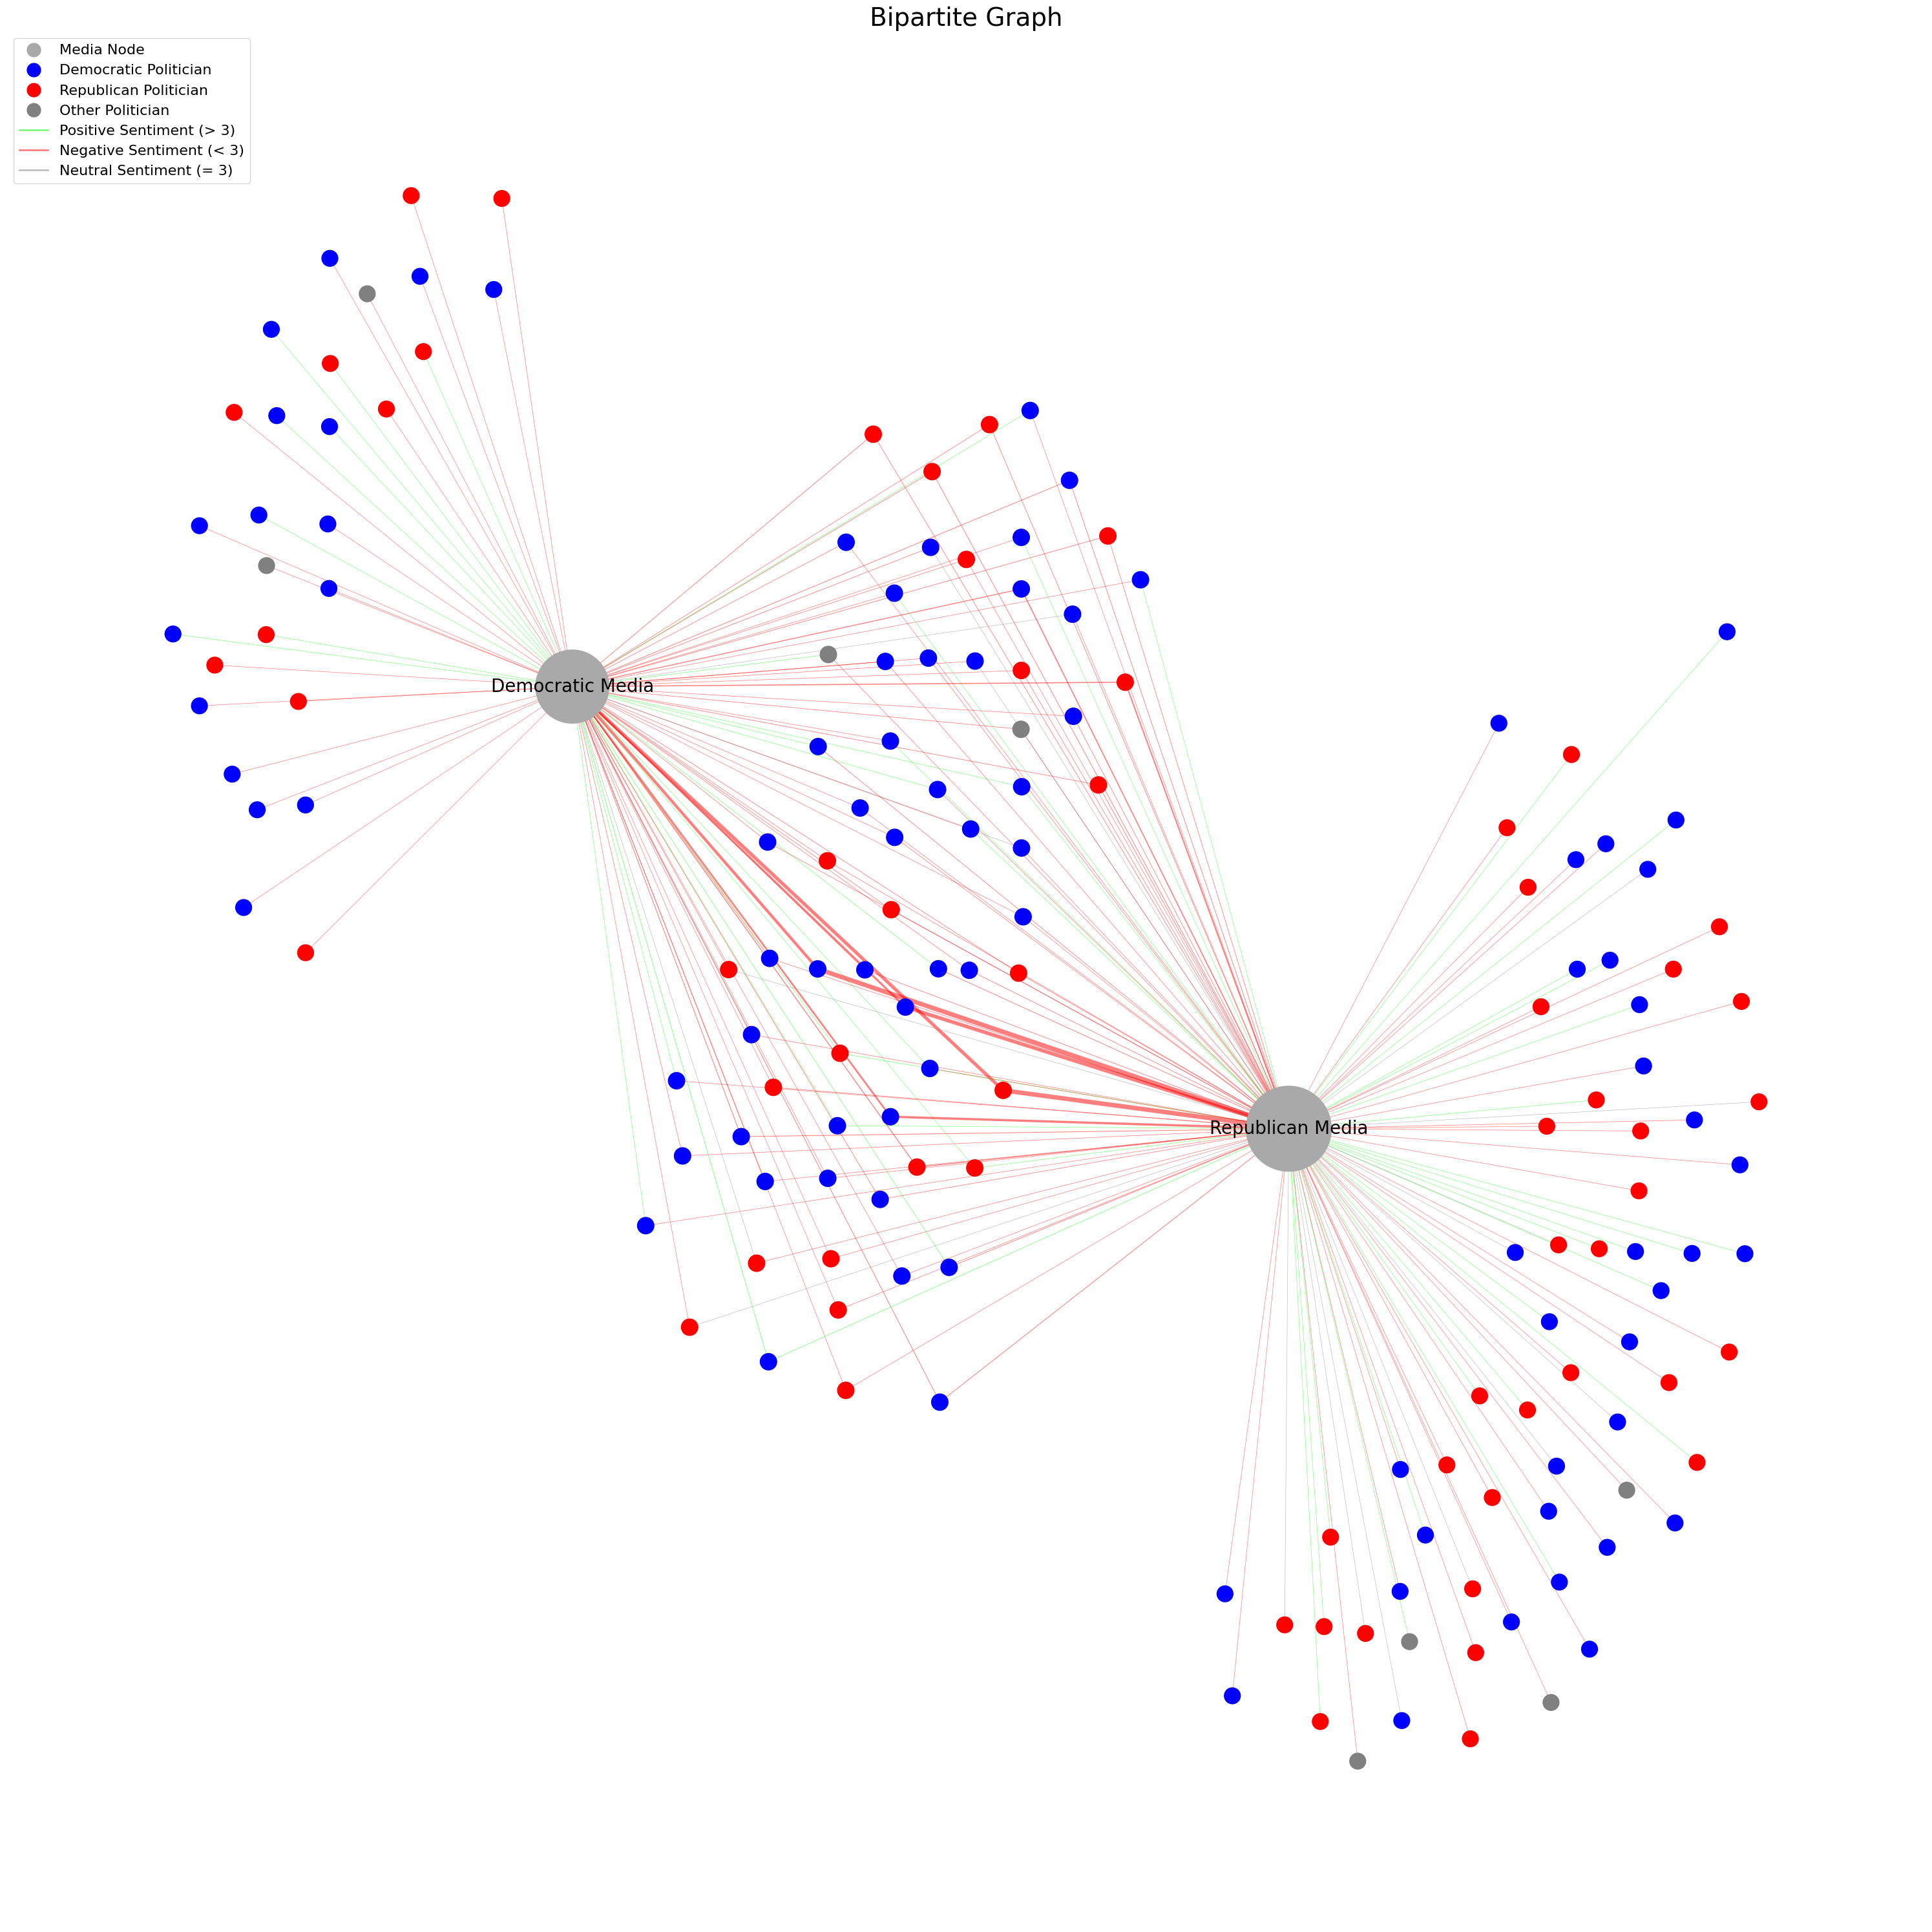

In [82]:
# Define the bipartite graph
media_nodes = [n for n, d in B.nodes(data=True) if d['type'] == 'Media']
politician_nodes = [n for n, d in B.nodes(data=True) if d['type'] == 'Politician']

nx.set_node_attributes(B, {n: 0 for n in media_nodes}, 'bipartite')
nx.set_node_attributes(B, {n: 1 for n in politician_nodes}, 'bipartite')

# Filter top politicians
politician_degrees = {n: B.degree(n) for n in politician_nodes}
top_politicians = sorted(politician_degrees, key=politician_degrees.get, reverse=True)[:]

nodes_to_keep = set(media_nodes + top_politicians)
subgraph = B.subgraph(nodes_to_keep).copy()

# Apply ForceAtlas2 layout
forceatlas2 = ForceAtlas2(
    outboundAttractionDistribution=False,
    linLogMode=False,
    adjustSizes=False,
    edgeWeightInfluence=1.0,
    jitterTolerance=1.0,
    barnesHutOptimize=True,
    barnesHutTheta=1.2,
    multiThreaded=False,
    scalingRatio=10.0,
    strongGravityMode=False,
    gravity=1.0,
    verbose=True
)

positions = forceatlas2.forceatlas2_networkx_layout(subgraph, iterations=1000, pos=None)

# Assign node colors
node_colors = []
for n in subgraph.nodes():
    if n in media_nodes:
        node_colors.append('darkgrey')
    elif n in republican_politicians:
        node_colors.append('red')
    elif n in democratic_politicians:
        node_colors.append('blue')
    else:
        node_colors.append('grey')

# Calculate node sizes
degrees = dict(subgraph.degree())
max_degree = max(degrees.values()) if degrees else 1
media_multiplier = 3  
min_node_size = 300  
max_node_size = 3000 

node_sizes = [
    (min_node_size + (max_node_size - min_node_size) * (degrees[n] / max_degree)) * 
    (media_multiplier if n in media_nodes else 1)
    for n in subgraph.nodes()
]

# Calculate edge weights
edge_weights_dict = nx.get_edge_attributes(subgraph, 'weight')
if edge_weights_dict:
    max_weight = max(edge_weights_dict.values())
    min_edge_width = 0.5  
    max_edge_width = 5.0  
    edge_weights = [
        min_edge_width + (max_edge_width - min_edge_width) * (subgraph[u][v]['weight'] / max_weight)
        for u, v in subgraph.edges()
    ]
else:
    edge_weights = [1 for _ in subgraph.edges()]

# Set edge colors based on sentiment using RGBA tuples
edge_colors = []
for u, v in subgraph.edges():
    sentiment = subgraph[u][v].get('sentiment', 3)
    if sentiment > 3:
        edge_colors.append((0, 1, 0, 0.2))  
    elif sentiment < 3:
        edge_colors.append((1, 0, 0, 0.2))  
    else:
        edge_colors.append((0.5, 0.5, 0.5, 0.05))

# Draw the graph
plt.figure(figsize=(30, 30))  
nx.draw_networkx_nodes(subgraph, positions,
                       node_color=node_colors,
                       node_size=node_sizes,
                       alpha=1.0)
nx.draw_networkx_edges(subgraph, positions,
                       edge_color=edge_colors,
                       width=edge_weights,
                       alpha=0.5)

# Add labels for media nodes
font_size = 20 
media_labels = {node: node for node in media_nodes}
nx.draw_networkx_labels(subgraph, positions, labels=media_labels, font_size=font_size, font_color='black')

# Create a legend
media_legend = mlines.Line2D([], [], color='darkgrey', marker='o', markersize=15, linestyle='None', label='Media Node')
democratic_legend = mlines.Line2D([], [], color='blue', marker='o', markersize=15, linestyle='None', label='Democratic Politician')
republican_legend = mlines.Line2D([], [], color='red', marker='o', markersize=15, linestyle='None', label='Republican Politician')
other_legend = mlines.Line2D([], [], color='grey', marker='o', markersize=15, linestyle='None', label='Other Politician')
positive_legend = mlines.Line2D([], [], color=(0, 1, 0, 0.5), linewidth=2, label='Positive Sentiment (> 3)')
negative_legend = mlines.Line2D([], [], color=(1, 0, 0, 0.5), linewidth=2, label='Negative Sentiment (< 3)')
neutral_legend = mlines.Line2D([], [], color=(0.5, 0.5, 0.5, 0.5), linewidth=2, label='Neutral Sentiment (= 3)')

plt.legend(handles=[media_legend, democratic_legend, republican_legend, other_legend, positive_legend, negative_legend, neutral_legend],
           loc='upper left', fontsize=16)  

plt.title("Bipartite Graph", fontsize=28)  
plt.axis('off')
plt.tight_layout()
plt.show()


In [66]:
# Output graph information
print(f"Number of nodes: {B.number_of_nodes()}")
print(f"Number of edges: {B.number_of_edges()}")
print("Sample nodes with attributes:")
for node, attrs in list(B.nodes(data=True))[:5]:
    print(f"{node}: {attrs}")
print("Sample edges with weights:")
for u, v, attrs in list(B.edges(data=True))[:5]:
    print(f"{u} - {v}: {attrs}")

Number of nodes: 165
Number of edges: 231
Sample nodes with attributes:
Democratic Media: {'bipartite': 0, 'type': 'Media'}
Republican Media: {'bipartite': 0, 'type': 'Media'}
Lisa Blunt Rochester: {'bipartite': 1, 'type': 'Politician'}
Paul Gosar: {'bipartite': 1, 'type': 'Politician'}
Adam Schiff: {'bipartite': 1, 'type': 'Politician'}
Sample edges with weights:
Democratic Media - Lisa Blunt Rochester: {'weight': 1, 'sentiment': 4.0}
Democratic Media - Paul Gosar: {'weight': 2, 'sentiment': 2.5}
Democratic Media - Adam Schiff: {'weight': 3, 'sentiment': 1.6666666666666667}
Democratic Media - Andrew Cuomo: {'weight': 21, 'sentiment': 1.9047619047619047}
Democratic Media - Amy Coney Barrett: {'weight': 9, 'sentiment': 2.0}


In [ ]:
# Set affiliations for media nodes
for node in media_nodes:
    if node == "Democratic Media":
        B.nodes[node]['affiliation'] = 'Democratic'
    elif node == "Republican Media":
        B.nodes[node]['affiliation'] = 'Republican'

interaction_counts = defaultdict(int)

# Iterate through edges
for u, v, attrs in B.edges(data=True):
    if B.nodes[u]['type'] == 'Media' and B.nodes[v]['type'] == 'Politician':
        media, politician = u, v
    elif B.nodes[v]['type'] == 'Media' and B.nodes[u]['type'] == 'Politician':
        media, politician = v, u
    else:
        continue

    media_affiliation = B.nodes[media].get('affiliation')
    politician_party = B.nodes[politician].get('party')

    # Count interactions
    if media_affiliation and politician_party:
        interaction_counts[(media_affiliation, politician_party)] += 1

print("Interaction counts:")
for (media_type, politician_type), count in interaction_counts.items():
    print(f"{media_type} Media mentioning {politician_type} Politicians: {count}")





Interaction counts:
Democratic Media mentioning Democratic Politicians: 60
Democratic Media mentioning Republican Politicians: 32
Democratic Media mentioning Unknown Politicians: 3
Democratic Media mentioning Other Politicians: 1
Republican Media mentioning Democratic Politicians: 77
Republican Media mentioning Republican Politicians: 52
Republican Media mentioning Unknown Politicians: 5
Republican Media mentioning Other Politicians: 1


# **Sentiment over time**

Here we want to take a look at the sentiment scores of politicians we analyzed earlier in the notebook. We want to create a timeline and see how sentiment towards these politicians change over time, and if some specific real-life events might have impacted this sentiment.

In [67]:
data_full_content['published_at'] = pd.to_datetime(data_full_content['published_at'], errors='coerce')
data_full_content = data_full_content.dropna(subset=['published_at'])
data_full_content['date'] = data_full_content['published_at'].dt.date

## Aggregate Sentiments Over Time
sentiment_over_time_file = 'sentiment_over_time.pkl'

sentiment_over_time = []

for politician, indices in politician_mentions.items():
    indices = list(indices)
    data_list = []

    for idx in indices:
        key = (idx, politician)
        if key in sentiment_scores:
            date = data_full_content.loc[idx, 'date']
            sentiment_score = sentiment_scores[key]
            data_list.append({'date': date, 'sentiment_score': sentiment_score})

    if data_list:
        politician_data = pd.DataFrame(data_list)
        daily_sentiment = (
            politician_data.groupby('date')['sentiment_score']
            .mean()
            .reset_index()
        )
        daily_sentiment['normalized_sentiment'] = (daily_sentiment['sentiment_score'] - 1) / 4
        daily_sentiment['politician'] = politician
        sentiment_over_time.append(daily_sentiment)

if sentiment_over_time:
    sentiment_over_time_df = pd.concat(sentiment_over_time, ignore_index=True)
else:
    sentiment_over_time_df = pd.DataFrame()
    print("No sentiment data available.")

# Save
sentiment_over_time_df.to_pickle(sentiment_over_time_file)
print("Sentiment over time data computed and saved.")

# Display
print(sentiment_over_time_df.head())


Sentiment over time data computed and saved.
         date  sentiment_score  normalized_sentiment    politician
0  2024-10-13         1.809783              0.202446  Donald Trump
1  2024-10-14         2.013393              0.253348  Donald Trump
2  2024-10-15         2.026316              0.256579  Donald Trump
3  2024-10-16         1.957627              0.239407  Donald Trump
4  2024-10-17         1.944664              0.236166  Donald Trump


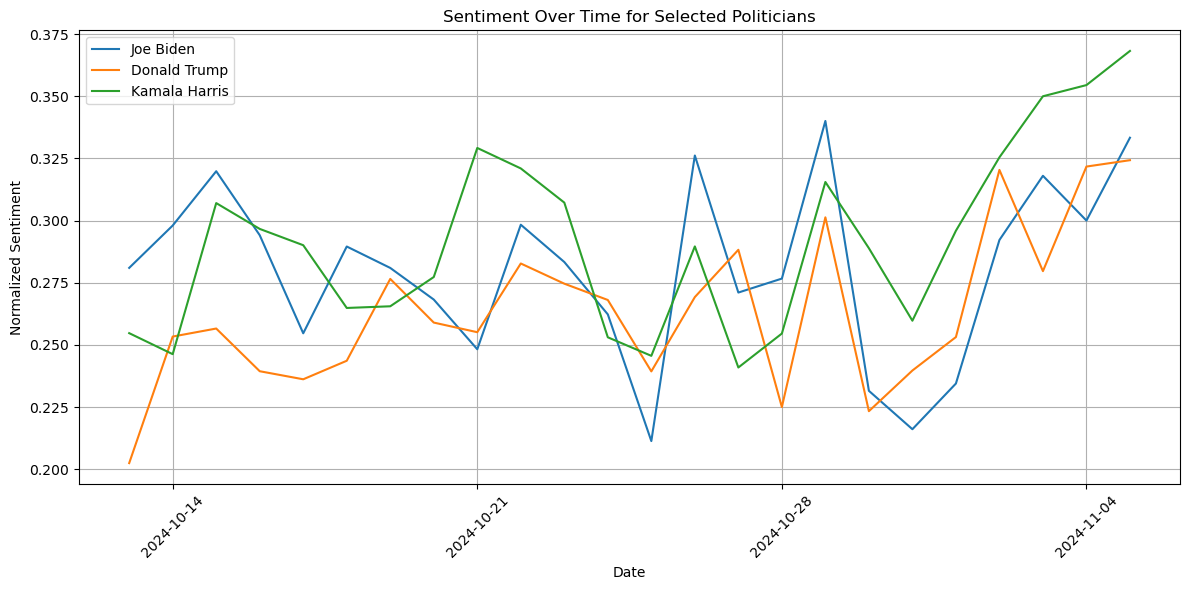

In [68]:
# Select top politicians to visualize
top_politicians = ['Joe Biden', 'Donald Trump', 'Kamala Harris']

plt.figure(figsize=(12, 6))

for politician in top_politicians:
    data = sentiment_over_time_df[sentiment_over_time_df['politician'] == politician]
    if not data.empty:
        plt.plot(data['date'], data['normalized_sentiment'], label=politician)
    else:
        print(f"No data available for {politician}")

plt.title('Sentiment Over Time for Selected Politicians')
plt.xlabel('Date')
plt.ylabel('Normalized Sentiment')
plt.legend()
plt.grid(True)
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=7)) 
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.xticks(rotation=45)

# Display
plt.tight_layout()
plt.show()

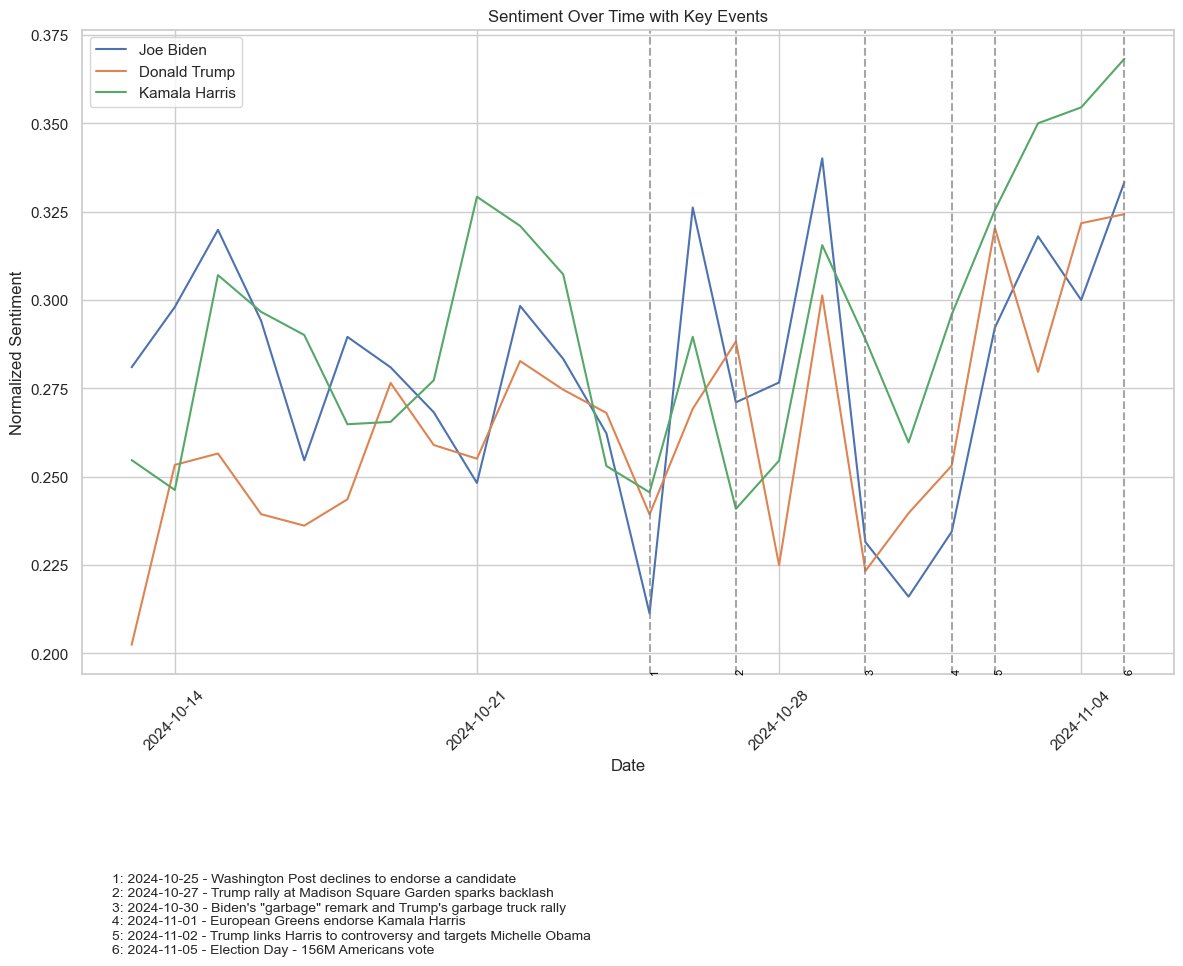

In [92]:
# Define key events
key_events = {
    '2024-10-25': 'Washington Post declines to endorse a candidate',
    '2024-10-27': 'Trump rally at Madison Square Garden sparks backlash',
    '2024-10-30': 'Biden\'s "garbage" remark and Trump\'s garbage truck rally',
    '2024-11-01': 'European Greens endorse Kamala Harris',
    '2024-11-02': 'Trump links Harris to controversy and targets Michelle Obama',
    '2024-11-05': 'Election Day - 156M Americans vote'
}

plt.figure(figsize=(12, 8))

for politician in top_politicians:
    data = sentiment_over_time_df[sentiment_over_time_df['politician'] == politician]
    if not data.empty:
        plt.plot(data['date'], data['normalized_sentiment'], label=politician)
    else:
        print(f"No data available for {politician}")

for i, (date_str, event) in enumerate(key_events.items(), start=1):
    event_date = pd.to_datetime(date_str).date()
    plt.axvline(x=event_date, color='grey', linestyle='--', alpha=0.7)
    plt.text(event_date, plt.ylim()[0], str(i), rotation=90, verticalalignment='bottom', fontsize=8, color='black')

plt.title('Sentiment Over Time with Key Events')
plt.xlabel('Date')
plt.ylabel('Normalized Sentiment')
plt.legend()
plt.grid(True)
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=7)) 
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.xticks(rotation=45)

event_legend = "\n".join([f"{i}: {date} - {desc}" for i, (date, desc) in enumerate(key_events.items(), start=1)])
plt.figtext(0.1, -0.2, event_legend, wrap=True, horizontalalignment='left', fontsize=10)

# Display
plt.tight_layout()
plt.show()


### Bipartite Community Decetion

#### Sentiment profiles for politicians 

In [70]:
# Initialize sentiment profiles
sentiment_profiles = {}

# Use the all_politicians variable defined in CELL INDEX: 18
for politician in B.nodes():
    if B.nodes[politician]['type'] == 'Politician':
        profile = {}
        # Extract sentiment scores from edges
        if B.has_edge("Democratic Media", politician):
            profile["Democratic Media"] = B["Democratic Media"][politician]["sentiment"]
        else:
            profile["Democratic Media"] = 0  # No connection

        if B.has_edge("Republican Media", politician):
            profile["Republican Media"] = B["Republican Media"][politician]["sentiment"]
        else:
            profile["Republican Media"] = 0  # No connection

        sentiment_profiles[politician] = profile

#### Create similarity based graph

In [71]:
# Convert sentiment profiles to a DataFrame
profiles_df = pd.DataFrame.from_dict(sentiment_profiles, orient="index").fillna(0)

# Compute similarity between sentiment profiles
similarity_matrix = cosine_similarity(profiles_df)

# Create a graph where edge weights are similarity scores
P = nx.Graph()
politicians = profiles_df.index.tolist()

for i, pol1 in enumerate(politicians):
    for j, pol2 in enumerate(politicians):
        if i != j and similarity_matrix[i, j] > 0:  # Ignore self-loops
            P.add_edge(pol1, pol2, weight=similarity_matrix[i, j])

#### Apply community detection

In [ ]:
# Detect communities
partition = community_louvain.best_partition(P, weight="weight")

# Group nodes by community
communities = defaultdict(list)
for politician, community_id in partition.items():
    communities[community_id].append(politician)

# Print community results
# for community_id, members in communities.items():
#     print(f"Community {community_id}: {len(members)} members")
#     print(f"Politicians: {members}\n")

#### Analyse and visualize communities 

In [73]:
for community_id, members in communities.items():
    print(f"Community {community_id}:")
    community_profiles = profiles_df.loc[members].mean()
    print(f"Average Sentiment Profile:")
    print(community_profiles)
    print("\n")

Community 0:
Average Sentiment Profile:
Democratic Media    2.527784
Republican Media    1.436312
dtype: float64


Community 1:
Average Sentiment Profile:
Democratic Media    0.172894
Republican Media    2.616683
dtype: float64




#### Plotting the Bipartite Community Network

100%|██████████| 2000/2000 [00:00<00:00, 2890.49it/s]


BarnesHut Approximation  took  0.14  seconds
Repulsion forces  took  0.43  seconds
Gravitational forces  took  0.02  seconds
Attraction forces  took  0.00  seconds
AdjustSpeedAndApplyForces step  took  0.07  seconds


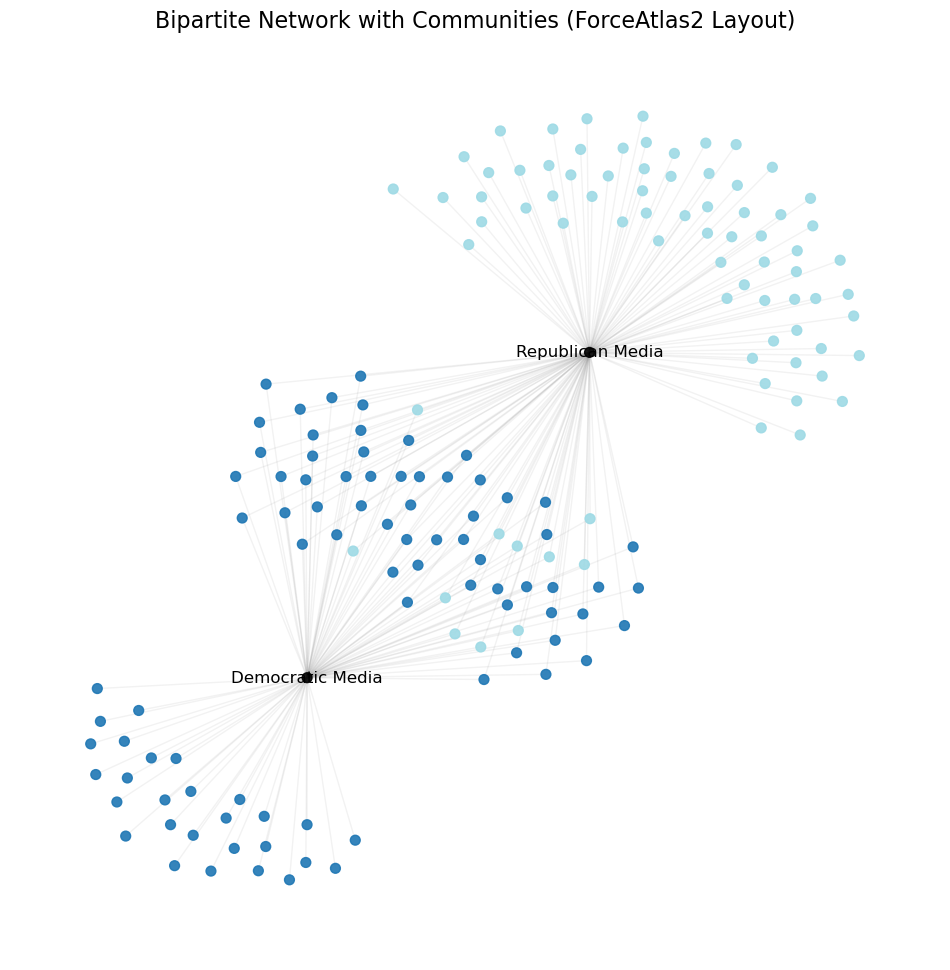

In [ ]:
# Assign community labels to politician nodes in B
for node in B.nodes():
    if B.nodes[node]['type'] == 'Politician':
        B.nodes[node]['community'] = partition.get(node, -1)  # Use -1 if the node is not in the partition
    else:
        B.nodes[node]['community'] = -1  # Assign -1 to media nodes to distinguish them

# Compute the ForceAtlas2 layout
forceatlas2 = ForceAtlas2(
    # Behavior alternatives
    outboundAttractionDistribution=False,  # Dissuade hubs
    linLogMode=False,  # NOT IMPLEMENTED
    adjustSizes=False,  # Prevent overlap (NOT IMPLEMENTED)
    edgeWeightInfluence=1.0,

    # Performance
    jitterTolerance=1.0,  # Tolerance
    barnesHutOptimize=True,
    barnesHutTheta=1.2,
    multiThreaded=False,

    # Tuning
    scalingRatio=2.0,
    strongGravityMode=False,
    gravity=1.0,

    # Log
    verbose=True
)

# Compute positions using ForceAtlas2
positions = forceatlas2.forceatlas2_networkx_layout(B, pos=None, iterations=2000)

# Prepare colors for nodes
# Get the list of community IDs, excluding -1 which is for media nodes
community_ids = [B.nodes[node]['community'] for node in B.nodes() if B.nodes[node]['community'] != -1]
unique_communities = list(set(community_ids))

# Create a color map
cmap = plt.get_cmap('tab20')  # You can choose any other colormap
cNorm = colors.Normalize(vmin=0, vmax=len(unique_communities) - 1)
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=cmap)

# Assign colors to communities
community_colors = {}
for idx, community in enumerate(sorted(unique_communities)):
    community_colors[community] = scalarMap.to_rgba(idx)

# Assign colors to nodes
node_colors = []
for node in B.nodes():
    if B.nodes[node]['type'] == 'Media':
        node_colors.append('black')  # Media nodes in black
    else:
        community = B.nodes[node]['community']
        if community != -1:
            node_colors.append(community_colors[community])
        else:
            node_colors.append('grey')  # For nodes without community assignment

# Draw the graph
plt.figure(figsize=(12, 12))
nx.draw_networkx_nodes(
    B,
    positions,
    node_size=50,
    node_color=node_colors,
    alpha=0.9
)
nx.draw_networkx_edges(B, positions, alpha=0.1, edge_color='gray')

# Optionally, add labels for Media nodes
media_labels = {node: node for node in B.nodes() if B.nodes[node]['type'] == 'Media'}
nx.draw_networkx_labels(B, positions, labels=media_labels, font_size=12, font_color='black')

plt.axis('off')
plt.title("Bipartite Network with Communities (ForceAtlas2 Layout)", fontsize=16)
plt.show()

#### Compute modularity

In [75]:
# Format communities for modularity calculation
formatted_communities = [members for members in communities.values()]

In [76]:
# Compute modularity score
modularity_score = modularity(P, formatted_communities, weight="weight")

print(f"Modularity Score: {modularity_score}")

Modularity Score: 0.1675932580351015


##### Comment on modularity

The modularity score is relatively low. As can be seen from the plot it also looks like there should be 3 different communities instead of only the two detected. Below are some possible reasons:

- The underlying network may not have strong divisions. If politicians have similar sentiment profiles across media outlets, the algorithm may find it challenging to partition them into well-defined communities.
Limited Dimensionality of Sentiment Profiles:

- With only two features (sentiment from Democratic Media and Republican Media), the sentiment profiles might not capture enough variation to distinguish communities effectively.
Overlapping Communities:

- Politicians might belong to overlapping communities, which modularity doesn't account for. Nodes connected to multiple communities can lower the overall modularity.
Size and Density of the Network:

- Smaller or sparser networks often yield lower modularity scores because there are fewer edges to define strong communities.
Resolution Limit of the Algorithm:

- The Louvain algorithm has a known resolution limit, which means it might merge small communities into larger ones, reducing modularity.